In [1]:
# Import libraries
import os
import sys
import requests
import sqlalchemy
from sqlalchemy.sql import text

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

from utils.database import get_db
import utils.models as models

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# from config import ACCOUNT_NUMBER, ACCOUNT_PASSWORD, CONSUMER_ID, REDIRECT_URI

# Create connection to Database and extraction of required data

In [2]:
# create connection to the database
db = get_db()

In [3]:
# Define requested ticker ID:
ticker_id = 40

In [4]:
# set the presentation format of float numbers within the dataframe

pd.set_option('display.float_format', lambda x: '%.3f' % x)


### Fetch "daily multipliers" table from database

In [5]:
query = db.query(models.FullDailyMultipliers)
df_daily_multipliers = pd.read_sql(query.statement, query.session.bind)
df_daily_multipliers.head()
# len(df_daily_multipliers.index)
df_daily_multipliers[df_daily_multipliers.isna().any(axis=1)]

,id,date,stock_id,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y
73,74,2013-03-31,1,NaN,NaN,NaN,NaN,13.372
138,139,2013-06-30,1,NaN,NaN,NaN,NaN,4.769
1023,1024,2016-12-31,1,NaN,NaN,NaN,NaN,1.616
1212,1213,2017-09-30,1,NaN,NaN,NaN,NaN,2.706
1276,1277,2017-12-31,1,NaN,NaN,NaN,NaN,-0.474
...,...,...,...,...,...,...,...,...
1214116,1214117,2018-03-31,503,NaN,NaN,NaN,NaN,0.954
1214181,1214182,2018-06-30,503,NaN,NaN,NaN,NaN,0.738
1214245,1214246,2018-09-30,503,NaN,NaN,NaN,NaN,2.227
1214370,1214371,2019-03-31,503,NaN,NaN,NaN,NaN,-3.510


In [6]:
# Choose the stock_id we want to check (ticker_id)
daily_multipliers = df_daily_multipliers.loc[df_daily_multipliers['stock_id'] == ticker_id]

# Delete all dates > 2.1.13
daily_multipliers = daily_multipliers.query('"2013-01-01" < date').copy().reset_index(drop=True)


daily_multipliers.head()
# df_daily_multipliers[df_daily_multipliers.isna().any(axis=1)]

,id,date,stock_id,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y
0,93936,2013-01-02,40,68409700000.000,91681700000.000,15.891,3.589,-3.464
1,93937,2013-01-03,40,67980000000.000,91252000000.000,15.791,3.567,-3.443
2,93938,2013-01-04,40,68279300000.000,91551300000.000,15.861,3.582,-3.458
3,93939,2013-01-07,40,67934000000.000,91206000000.000,15.781,3.564,-3.440
4,93940,2013-01-08,40,67642400000.000,90914400000.000,15.713,3.549,-3.425


### Fetch "end of day prices" table from database

In [7]:

query = db.query(models.EndOfDayPrices)
df_end_of_day_prices = pd.read_sql(query.statement, query.session.bind)
df_end_of_day_prices.head()

# len(df_end_of_day_prices.head().index)


,id,stock_id,date,close_price
0,1,1,2012-01-03,83.490
1,2,1,2012-01-04,84.180
2,3,1,2012-01-05,83.800
3,4,1,2012-01-06,83.370
4,5,1,2012-01-09,83.870


### Select specific stock from end of day prices table (Apple Stock)

In [8]:
# Choose the stock_id we want to check (ticker_id)
end_of_day_prices = df_end_of_day_prices.loc[df_end_of_day_prices['stock_id'] == ticker_id]

# Delete all dates > 2.1.13
end_of_day_prices = end_of_day_prices.query('"2013-01-01" < date').copy().reset_index(drop=True)


end_of_day_prices.head()
end_of_day_prices[end_of_day_prices.isna().any(axis=1)]

,id,stock_id,date,close_price


### Fetch "pfree cash flow multiplier" table from database

In [9]:
# fetch the end of day prices table from database

query = db.query(models.PFreeCashFlowMultiplier)
df_pfree_cash_flow = pd.read_sql(query.statement, query.session.bind)
# df_pfree_cash_flow.head()

# Choose the stock_id we want to check (ticker_id)
pfree_cash_flow = df_pfree_cash_flow.loc[df_pfree_cash_flow['stock_id'] == ticker_id]

# Delete all dates > 2.1.13
pfree_cash_flow = pfree_cash_flow.query('"2013-01-01" < date').copy().reset_index(drop=True)


pfree_cash_flow.shape
pfree_cash_flow[pfree_cash_flow.isna().any(axis=1)]


,id,stock_id,date,year,quarter,pfree_cash_flow_ratio
2267,109573,40,2022-01-03,2022,1,NaN
2268,109574,40,2022-01-04,2022,1,NaN
2269,109575,40,2022-01-05,2022,1,NaN
2270,109576,40,2022-01-06,2022,1,NaN
2271,109577,40,2022-01-07,2022,1,NaN
...,...,...,...,...,...,...
2490,109796,40,2022-11-21,2022,4,NaN
2491,109797,40,2022-11-22,2022,4,NaN
2492,109798,40,2022-11-23,2022,4,NaN
2493,109799,40,2022-11-25,2022,4,NaN


### Fetch "graham number" table from database

In [10]:
# fetch the end of day prices table from database

query = db.query(models.GrahamNumber)
df_graham_number = pd.read_sql(query.statement, query.session.bind)
# df_pfree_cash_flow.head()

# Choose the stock_id we want to check (ticker_id)
graham_number = df_graham_number.loc[df_graham_number['stock_id'] == ticker_id]

# filter year =< 2012
graham_number = graham_number.query('2012 < year').copy().reset_index(drop=True)

# df_graham_number.dtypes
graham_number.shape

graham_number[graham_number.isna().any(axis=1)]


,id,stock_id,year,quarter,graham_value
0,1605,40,2022,1,NaN
1,1606,40,2022,2,NaN
2,1607,40,2022,3,NaN


### Fetch "overview data" table from database

In [11]:
# fetch the overview data table from database

overview = models.QuarterlyOverview
query = db.query(overview.stock_id, overview.year, overview.quarter, overview.currentRatio )
df_overview_data = pd.read_sql(query.statement, query.session.bind)
# df_pfree_cash_flow.head()

# Choose the stock_id we want to check (ticker_id)
overview_data = df_overview_data.loc[df_overview_data['stock_id'] == ticker_id]

# filter year =< 2012
overview_data = overview_data.query('2012 < year').copy().reset_index(drop=True)

# df_graham_number.dtypes
# overview_data.shape

overview_data

overview_data[overview_data.isna().any(axis=1)]

,stock_id,year,quarter,currentRatio
4,40,2021,0,NaN
9,40,2020,0,NaN
14,40,2019,0,NaN
19,40,2018,0,NaN
24,40,2017,0,NaN
29,40,2016,0,NaN
34,40,2015,0,NaN
39,40,2014,0,NaN
44,40,2013,0,NaN


# Preprocessing of the data

# Join all five dataframes

In [12]:
# First, combine the two dataframes: "end of day prices" and "daily multipliers" into one joined dataframe (using outer join to maintain all rows)
joined_dataframe = pd.merge(end_of_day_prices, daily_multipliers, on='date', how='inner')

# Create 2 new columns for "date_plus_3m" & "market_cap_plus_3m"
day_gap = 60
date_plus_3m = joined_dataframe.loc[day_gap:,'date'].values
market_cap_plus_3m = joined_dataframe.loc[day_gap:,'market_cap'].values


joined_dataframe.drop(joined_dataframe.tail(day_gap).index, inplace = True)
joined_dataframe['date_plus_3m'] = date_plus_3m
joined_dataframe['market_cap_plus_3m'] = market_cap_plus_3m

# Rename columns
joined_dataframe.rename(columns = {'id_x': 'id', 'stock_id_x':'stock_id'}, inplace=True)

# Setting the index column to column 'id'
joined_dataframe['id'] = joined_dataframe.index

# Dropping redundant columns
joined_dataframe = joined_dataframe.drop(['stock_id_y', 'id_y'], axis=1)

# Rename dataframe for clarity purposes
multiplier_with_closing_prices = joined_dataframe

multiplier_with_closing_prices

# Check for Nan values in joined dataframe
multiplier_with_closing_prices[multiplier_with_closing_prices.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m


In [13]:
# Second, join the two dataframes: "multiplier_with_closing_prices" and "pfree_cash_flow" into one joined dataframe (using outer join to maintain all rows)

joined_dataframe = pd.merge(multiplier_with_closing_prices, pfree_cash_flow, on='date', how='left')

# Rename columns
joined_dataframe.rename(columns = {'id_x': 'id', 'stock_id_x':'stock_id'}, inplace=True)

# Convert "date" column's type from object to datetime and "stock id" to int
joined_dataframe['date'] = pd.to_datetime(joined_dataframe['date'])
joined_dataframe['stock_id'] = joined_dataframe['stock_id'].astype('int')

# Handle Nan values that were formed due to the left join of the two dataframes
joined_dataframe["pfree_cash_flow_ratio"] = joined_dataframe["pfree_cash_flow_ratio"].interpolate(axis=0, limit_area='inside', limit=5)

joined_dataframe["year"] = joined_dataframe["date"].dt.year
joined_dataframe['quarter'] = joined_dataframe['date'].dt.quarter

# Setting the index column to column 'id'
joined_dataframe['id'] = joined_dataframe.index

# Dropping redundant columns
joined_dataframe = joined_dataframe.drop(['stock_id_y', 'id_y'], axis=1)

# Rename dataframe for clarity purposes
multiplier_with_closing_prices_and_cash_flow = joined_dataframe

# multiplier_with_closing_prices_and_cash_flow

# multiplier_with_closing_prices_and_cash_flow.head()
multiplier_with_closing_prices_and_cash_flow[multiplier_with_closing_prices_and_cash_flow.isna().any(axis=1)]



,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio
2267,2267,40,2022-01-03,226.690,127687000000.000,153007000000.000,21.924,19.058,1.073,2022-03-30,135119000000.000,2022,1,NaN
2268,2268,40,2022-01-04,227.840,128335000000.000,153655000000.000,22.035,19.154,1.079,2022-03-31,134701000000.000,2022,1,NaN
2269,2269,40,2022-01-05,225.140,126814000000.000,152134000000.000,21.774,18.927,1.066,2022-04-01,135425000000.000,2022,1,NaN
2270,2270,40,2022-01-06,225.170,126831000000.000,152151000000.000,21.777,18.930,1.066,2022-04-04,136400000000.000,2022,1,NaN
2271,2271,40,2022-01-07,227.290,128025000000.000,153345000000.000,21.982,19.108,1.076,2022-04-05,136227000000.000,2022,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,40,2022-08-26,240.650,128731000000.000,160050000000.000,20.342,53.144,0.100,2022-11-21,153756000000.000,2022,3,NaN
2431,2431,40,2022-08-29,239.380,128052000000.000,159371000000.000,20.235,52.864,0.099,2022-11-22,153164000000.000,2022,3,NaN
2432,2432,40,2022-08-30,239.120,127913000000.000,159232000000.000,20.213,52.806,0.099,2022-11-23,151216000000.000,2022,3,NaN
2433,2433,40,2022-08-31,240.300,128544000000.000,159863000000.000,20.313,53.067,0.100,2022-11-25,151398000000.000,2022,3,NaN


In [14]:
# Next, merge the dataframe - "graham number", which has quarterly data with the previously joined dataframe,

joined_dataframe = pd.merge(multiplier_with_closing_prices_and_cash_flow, graham_number, on=['year', 'quarter'], how='left')

# Rename columns
joined_dataframe.rename(columns = {'id_x': 'id', 'stock_id_x':'stock_id'}, inplace=True)

# Dropping redundant columns
joined_dataframe = joined_dataframe.drop(['stock_id_y', 'id_y'], axis=1)

# Rename dataframe for clarity purposes
four_joined_dataframes = joined_dataframe

# four_joined_dataframes.head()

four_joined_dataframes[four_joined_dataframes.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value
2267,2267,40,2022-01-03,226.690,127687000000.000,153007000000.000,21.924,19.058,1.073,2022-03-30,135119000000.000,2022,1,NaN,NaN
2268,2268,40,2022-01-04,227.840,128335000000.000,153655000000.000,22.035,19.154,1.079,2022-03-31,134701000000.000,2022,1,NaN,NaN
2269,2269,40,2022-01-05,225.140,126814000000.000,152134000000.000,21.774,18.927,1.066,2022-04-01,135425000000.000,2022,1,NaN,NaN
2270,2270,40,2022-01-06,225.170,126831000000.000,152151000000.000,21.777,18.930,1.066,2022-04-04,136400000000.000,2022,1,NaN,NaN
2271,2271,40,2022-01-07,227.290,128025000000.000,153345000000.000,21.982,19.108,1.076,2022-04-05,136227000000.000,2022,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,40,2022-08-26,240.650,128731000000.000,160050000000.000,20.342,53.144,0.100,2022-11-21,153756000000.000,2022,3,NaN,NaN
2431,2431,40,2022-08-29,239.380,128052000000.000,159371000000.000,20.235,52.864,0.099,2022-11-22,153164000000.000,2022,3,NaN,NaN
2432,2432,40,2022-08-30,239.120,127913000000.000,159232000000.000,20.213,52.806,0.099,2022-11-23,151216000000.000,2022,3,NaN,NaN
2433,2433,40,2022-08-31,240.300,128544000000.000,159863000000.000,20.313,53.067,0.100,2022-11-25,151398000000.000,2022,3,NaN,NaN


In [15]:
# Finally, merge the remaining dataframe - "overview", which has quarterly data with the previously joined dataframe,


joined_dataframe = pd.merge(four_joined_dataframes, overview_data, on=['stock_id', 'year', 'quarter'], how='left')

# Rename dataframe for clarity purposes
final_joined_dataframe = joined_dataframe

# final_joined_dataframe.head()
final_joined_dataframe[final_joined_dataframe.isna().any(axis=1)]

# final_joined_dataframe

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value,currentRatio
2267,2267,40,2022-01-03,226.690,127687000000.000,153007000000.000,21.924,19.058,1.073,2022-03-30,135119000000.000,2022,1,NaN,NaN,1.437
2268,2268,40,2022-01-04,227.840,128335000000.000,153655000000.000,22.035,19.154,1.079,2022-03-31,134701000000.000,2022,1,NaN,NaN,1.437
2269,2269,40,2022-01-05,225.140,126814000000.000,152134000000.000,21.774,18.927,1.066,2022-04-01,135425000000.000,2022,1,NaN,NaN,1.437
2270,2270,40,2022-01-06,225.170,126831000000.000,152151000000.000,21.777,18.930,1.066,2022-04-04,136400000000.000,2022,1,NaN,NaN,1.437
2271,2271,40,2022-01-07,227.290,128025000000.000,153345000000.000,21.982,19.108,1.076,2022-04-05,136227000000.000,2022,1,NaN,NaN,1.437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,40,2022-08-26,240.650,128731000000.000,160050000000.000,20.342,53.144,0.100,2022-11-21,153756000000.000,2022,3,NaN,NaN,1.679
2431,2431,40,2022-08-29,239.380,128052000000.000,159371000000.000,20.235,52.864,0.099,2022-11-22,153164000000.000,2022,3,NaN,NaN,1.679
2432,2432,40,2022-08-30,239.120,127913000000.000,159232000000.000,20.213,52.806,0.099,2022-11-23,151216000000.000,2022,3,NaN,NaN,1.679
2433,2433,40,2022-08-31,240.300,128544000000.000,159863000000.000,20.313,53.067,0.100,2022-11-25,151398000000.000,2022,3,NaN,NaN,1.679


In [16]:
# create a new column - "diff_in_market_cap_perc" where:
# 1. calculates the change in market cap value 3 months apart and presents the difference in percentage

col1 = final_joined_dataframe['market_cap']
col2 = final_joined_dataframe['market_cap_plus_3m']

final_joined_dataframe['diff_in_mc'] = col2.sub(col1, axis=0)
final_joined_dataframe['diff_in_mc_perc'] = ((col2.sub(col1, axis=0)).div(col1)).mul(100)

# final_joined_dataframe.shape
final_joined_dataframe.head(200)

# final_joined_dataframe[final_joined_dataframe.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value,currentRatio,diff_in_mc,diff_in_mc_perc
0,0,40,2013-01-02,89.150,68409700000.000,91681700000.000,15.891,3.589,-3.464,2013-04-01,76571900000.000,2013,1,11.877,62.376,5.581,8162200000.000,11.931
1,1,40,2013-01-03,88.590,67980000000.000,91252000000.000,15.791,3.567,-3.443,2013-04-02,79633000000.000,2013,1,11.802,62.376,5.581,11653000000.000,17.142
2,2,40,2013-01-04,88.980,68279300000.000,91551300000.000,15.861,3.582,-3.458,2013-04-03,78442900000.000,2013,1,11.854,62.376,5.581,10163600000.000,14.885
3,3,40,2013-01-07,88.530,67934000000.000,91206000000.000,15.781,3.564,-3.440,2013-04-04,79243800000.000,2013,1,11.794,62.376,5.581,11309800000.000,16.648
4,4,40,2013-01-08,88.150,67642400000.000,90914400000.000,15.713,3.549,-3.425,2013-04-05,77866700000.000,2013,1,11.743,62.376,5.581,10224300000.000,15.115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,40,2013-10-10,109.920,82808900000.000,101717000000.000,17.095,3.811,0.665,2014-01-07,87802900000.000,2013,4,14.755,66.162,3.444,4994000000.000,6.031
196,196,40,2013-10-11,110.890,83539700000.000,102448000000.000,17.246,3.845,0.671,2014-01-08,87388100000.000,2013,4,14.885,66.162,3.444,3848400000.000,4.607
197,197,40,2013-10-14,111.580,84059500000.000,102967000000.000,17.353,3.869,0.675,2014-01-09,89658100000.000,2013,4,14.978,66.162,3.444,5598600000.000,6.660
198,198,40,2013-10-15,111.440,83954000000.000,102862000000.000,17.331,3.864,0.675,2014-01-10,88979300000.000,2013,4,14.959,66.162,3.444,5025300000.000,5.986


# 1. Optimizing the random forest model

In [17]:
# Define requested model and label thresholds:

label_threshold_lst = [1, 5, 10, 15, 20]

model_threshold_lst = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


In [18]:
# First, convert "date_plus_3m" columns type from 'string' to 'datetime'
final_joined_dataframe['date_plus_3m'] = pd.to_datetime(final_joined_dataframe['date_plus_3m'])

# Split the data to 60% train, 20% validation, 20% test
train = final_joined_dataframe.query('"2013-01-01" < date <= "2017-03-30"').copy()
validation = final_joined_dataframe.query('"2017-03-30" < date <= "2018-08-29"').copy()
test = final_joined_dataframe.query('"2018-08-29" < date <= "2020-02-01"').copy()


# Set the x (=features)
X_Cols = ['enterprise_val','pe_ratio','pb_ratio','trailing_peg_1_y', 'pfree_cash_flow_ratio', 'graham_value', 'currentRatio']

# Split X to train and test
X_train, X_validation = train[X_Cols], validation[X_Cols]


In [19]:
train.shape

(1069, 18)

In [20]:
validation.shape

(357, 18)

In [21]:
test.shape

(357, 18)

In [22]:
# Model optimization using ParameterGrid() - ~percentage~ of profit

profit_with_params_dict = {}
# y_pred_dict_per_model = {} # Saving the prediction of each model so we could show all ROC curves

rf_clf_full_params = {
                'n_estimators':[51,101,151], # The number of trees in the forest
                'criterion':["gini", "entropy"], # The function to measure the quality of a split.
                'max_depth':[5, 7, 9, 11],    # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
                'max_features':[3, 5, 7, 8], # The number of features to consider when looking for the best split results
                'random_state':[711]
                 }


# classifier = RandomForestClassifier
params = rf_clf_full_params
all_rf_params_permutations = list(ParameterGrid(params))
# print(len(list(ParameterGrid(params))))
# print(list(ParameterGrid(params)))

# Loop through different model parameters in order to find the optimized set of parameters for the requested stock, testing on a validation set:
for label_thresh in tqdm(label_threshold_lst, desc="label threshold"):
    # final_joined_dataframe['label'] = (final_joined_dataframe["diff_in_mc_perc"] > label_thresh).astype(int)    # create the label column  according to the first two parameters - label and model threshold
    train['label'] = (train["diff_in_mc_perc"] > label_thresh).astype(int)
    validation['label'] = (validation["diff_in_mc_perc"] > label_thresh).astype(int)
    Y_Cols = ['label']
    y_train, y_validation = train[Y_Cols].values.ravel(), validation[Y_Cols].values.ravel()  # this changes according to the tested label threshold, therefor inserted into the for loop
    for model_thresh in tqdm(model_threshold_lst, desc="model threshold"):
        for params in tqdm(all_rf_params_permutations, desc="model params"):
            rand_frst_clf = RandomForestClassifier(**params)  # run through the different classifier's parameters options
            rand_frst_clf.fit(X_train, y_train)   # fit (train) the data to the model
            y_pred_proba = rand_frst_clf.predict_proba(X_validation)[:,1] # Make predictions (validation)
            y_pred = y_pred_proba > model_thresh
            validation['prediction'] = y_pred.astype(int)
            validation['profit_percentage'] = validation['diff_in_mc_perc'] * validation['prediction']
            profit_perc_sum = round(validation['profit_percentage'].sum(), 3)
            profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)
            print('profit_perc_sum', profit_perc_sum, 'profit_perc_mean', profit_perc_mean, 'denominator', validation[validation['prediction']==1].shape[0])
            profit_with_params_dict[profit_perc_mean] = [label_thresh, model_thresh, params]

profit_keys_lst = list(profit_with_params_dict.keys())
profit_keys_lst_not_null = [i for i in profit_keys_lst if not pd.isna(i)]
profit_keys_lst_not_null.sort(reverse=True)
max_profit_perc_in_sorted_dict = {i: profit_with_params_dict[i] for i in profit_keys_lst_not_null[:5]}

print(max_profit_perc_in_sorted_dict)

model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   2%|▏         | 2/96 [00:00<00:11,  7.87it/s]

profit_perc_sum 433.216 profit_perc_mean 7.877 denominator 55
profit_perc_sum 315.664 profit_perc_mean 7.516 denominator 42




model params:   3%|▎         | 3/96 [00:00<00:16,  5.49it/s]

model params:   4%|▍         | 4/96 [00:00<00:14,  6.34it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24
profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:   5%|▌         | 5/96 [00:00<00:17,  5.35it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:   6%|▋         | 6/96 [00:01<00:21,  4.28it/s]

model params:   7%|▋         | 7/96 [00:01<00:18,  4.93it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24
profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:   8%|▊         | 8/96 [00:01<00:19,  4.49it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:   9%|▉         | 9/96 [00:02<00:24,  3.59it/s]

model params:  10%|█         | 10/96 [00:02<00:20,  4.27it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23
profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  11%|█▏        | 11/96 [00:02<00:20,  4.09it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  12%|█▎        | 12/96 [00:02<00:24,  3.47it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23
profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  15%|█▍        | 14/96 [00:03<00:17,  4.59it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  16%|█▌        | 15/96 [00:03<00:18,  4.32it/s]

model params:  17%|█▋        | 16/96 [00:03<00:16,  4.90it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24
profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  18%|█▊        | 17/96 [00:03<00:16,  4.69it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  19%|█▉        | 18/96 [00:04<00:19,  3.96it/s]

model params:  20%|█▉        | 19/96 [00:04<00:17,  4.46it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23
profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  21%|██        | 20/96 [00:04<00:18,  4.08it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  22%|██▏       | 21/96 [00:04<00:22,  3.29it/s]

model params:  23%|██▎       | 22/96 [00:05<00:19,  3.85it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24
profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  24%|██▍       | 23/96 [00:05<00:19,  3.65it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  25%|██▌       | 24/96 [00:05<00:23,  3.06it/s]

model params:  26%|██▌       | 25/96 [00:05<00:18,  3.85it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24
profit_perc_sum 210.65 profit_perc_mean 7.802 denominator 27




model params:  27%|██▋       | 26/96 [00:06<00:16,  4.15it/s]

profit_perc_sum 232.107 profit_perc_mean 8.29 denominator 28




model params:  28%|██▊       | 27/96 [00:06<00:17,  3.90it/s]

model params:  29%|██▉       | 28/96 [00:06<00:14,  4.59it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  30%|███       | 29/96 [00:06<00:15,  4.36it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  31%|███▏      | 30/96 [00:07<00:18,  3.64it/s]

model params:  32%|███▏      | 31/96 [00:07<00:15,  4.16it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22
profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  33%|███▎      | 32/96 [00:07<00:16,  3.78it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  34%|███▍      | 33/96 [00:08<00:20,  3.04it/s]

model params:  35%|███▌      | 34/96 [00:08<00:17,  3.58it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23
profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  36%|███▋      | 35/96 [00:08<00:18,  3.38it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  38%|███▊      | 36/96 [00:09<00:23,  2.60it/s]

model params:  39%|███▊      | 37/96 [00:09<00:18,  3.23it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23
profit_perc_sum 433.216 profit_perc_mean 7.877 denominator 55




model params:  40%|███▉      | 38/96 [00:09<00:17,  3.36it/s]

profit_perc_sum 264.384 profit_perc_mean 8.012 denominator 33




model params:  41%|████      | 39/96 [00:10<00:19,  2.99it/s]



profit_perc_sum 259.526 profit_perc_mean 8.11 denominator 32
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22


model params:  42%|████▏     | 40/96 [00:10<00:16,  3.45it/s]

model params:  43%|████▎     | 41/96 [00:10<00:17,  3.23it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  44%|████▍     | 42/96 [00:11<00:20,  2.67it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  45%|████▍     | 43/96 [00:11<00:17,  3.01it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  46%|████▌     | 44/96 [00:11<00:18,  2.76it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  47%|████▋     | 45/96 [00:12<00:23,  2.21it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  48%|████▊     | 46/96 [00:12<00:19,  2.57it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  49%|████▉     | 47/96 [00:13<00:19,  2.46it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  50%|█████     | 48/96 [00:13<00:23,  2.03it/s]

model params:  51%|█████     | 49/96 [00:14<00:18,  2.57it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23
profit_perc_sum 433.216 profit_perc_mean 7.877 denominator 55




model params:  52%|█████▏    | 50/96 [00:14<00:16,  2.71it/s]

profit_perc_sum 433.216 profit_perc_mean 7.877 denominator 55




model params:  53%|█████▎    | 51/96 [00:14<00:19,  2.35it/s]

profit_perc_sum 283.643 profit_perc_mean 8.104 denominator 35




model params:  54%|█████▍    | 52/96 [00:15<00:16,  2.69it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  55%|█████▌    | 53/96 [00:15<00:17,  2.46it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  56%|█████▋    | 54/96 [00:16<00:20,  2.03it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  57%|█████▋    | 55/96 [00:16<00:17,  2.36it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  58%|█████▊    | 56/96 [00:17<00:17,  2.29it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  59%|█████▉    | 57/96 [00:17<00:19,  2.01it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  60%|██████    | 58/96 [00:17<00:15,  2.40it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  61%|██████▏   | 59/96 [00:18<00:15,  2.39it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  62%|██████▎   | 60/96 [00:18<00:17,  2.10it/s]

model params:  64%|██████▎   | 61/96 [00:19<00:13,  2.65it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22
profit_perc_sum 433.216 profit_perc_mean 7.877 denominator 55




model params:  65%|██████▍   | 62/96 [00:19<00:11,  2.86it/s]

profit_perc_sum 433.216 profit_perc_mean 7.877 denominator 55




model params:  66%|██████▌   | 63/96 [00:19<00:12,  2.64it/s]

profit_perc_sum 228.507 profit_perc_mean 7.88 denominator 29




model params:  67%|██████▋   | 64/96 [00:20<00:10,  3.04it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  68%|██████▊   | 65/96 [00:20<00:10,  2.83it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  69%|██████▉   | 66/96 [00:21<00:13,  2.30it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  70%|██████▉   | 67/96 [00:21<00:11,  2.63it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  71%|███████   | 68/96 [00:21<00:11,  2.48it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  72%|███████▏  | 69/96 [00:22<00:12,  2.10it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  73%|███████▎  | 70/96 [00:22<00:10,  2.46it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  74%|███████▍  | 71/96 [00:23<00:11,  2.27it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  75%|███████▌  | 72/96 [00:24<00:15,  1.60it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  76%|███████▌  | 73/96 [00:24<00:11,  1.97it/s]

profit_perc_sum 257.149 profit_perc_mean 7.792 denominator 33




model params:  77%|███████▋  | 74/96 [00:24<00:10,  2.12it/s]

profit_perc_sum 285.497 profit_perc_mean 7.93 denominator 36




model params:  78%|███████▊  | 75/96 [00:25<00:10,  1.96it/s]

profit_perc_sum 214.09 profit_perc_mean 7.929 denominator 27




model params:  79%|███████▉  | 76/96 [00:25<00:08,  2.33it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  80%|████████  | 77/96 [00:26<00:09,  2.08it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  81%|████████▏ | 78/96 [00:27<00:10,  1.73it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  82%|████████▏ | 79/96 [00:27<00:08,  2.03it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  83%|████████▎ | 80/96 [00:27<00:08,  1.98it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  84%|████████▍ | 81/96 [00:29<00:10,  1.44it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  85%|████████▌ | 82/96 [00:29<00:08,  1.71it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  86%|████████▋ | 83/96 [00:29<00:07,  1.77it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  88%|████████▊ | 84/96 [00:30<00:07,  1.66it/s]

model params:  89%|████████▊ | 85/96 [00:30<00:05,  2.14it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 271.421 profit_perc_mean 7.983 denominator 34




model params:  90%|████████▉ | 86/96 [00:31<00:04,  2.40it/s]

profit_perc_sum 295.714 profit_perc_mean 8.214 denominator 36




model params:  91%|█████████ | 87/96 [00:31<00:03,  2.40it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  92%|█████████▏| 88/96 [00:31<00:02,  2.86it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  93%|█████████▎| 89/96 [00:32<00:02,  2.80it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  94%|█████████▍| 90/96 [00:32<00:02,  2.41it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  95%|█████████▍| 91/96 [00:32<00:01,  2.76it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  96%|█████████▌| 92/96 [00:33<00:01,  2.56it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  97%|█████████▋| 93/96 [00:33<00:01,  2.11it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  98%|█████████▊| 94/96 [00:34<00:00,  2.48it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  99%|█████████▉| 95/96 [00:34<00:00,  2.39it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params: 100%|██████████| 96/96 [00:35<00:00,  2.72it/s]

model threshold:  17%|█▋        | 1/6 [00:35<02:56, 35.35s/it]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:10,  9.25it/s]

profit_perc_sum 346.316 profit_perc_mean 7.696 denominator 45
profit_perc_sum



model params:   2%|▏         | 2/96 [00:00<00:16,  5.79it/s]

 193.143 profit_perc_mean 8.048 denominator 24




model params:   3%|▎         | 3/96 [00:00<00:22,  4.18it/s]

model params:   4%|▍         | 4/96 [00:00<00:18,  4.98it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24
profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:   5%|▌         | 5/96 [00:01<00:21,  4.27it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:   6%|▋         | 6/96 [00:01<00:26,  3.39it/s]

model params:   7%|▋         | 7/96 [00:01<00:22,  3.93it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22
profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:   8%|▊         | 8/96 [00:01<00:24,  3.58it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:   9%|▉         | 9/96 [00:02<00:29,  2.93it/s]

model params:  10%|█         | 10/96 [00:02<00:24,  3.49it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23
profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  11%|█▏        | 11/96 [00:02<00:25,  3.37it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  12%|█▎        | 12/96 [00:03<00:29,  2.82it/s]

model params:  14%|█▎        | 13/96 [00:03<00:23,  3.54it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23
profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  15%|█▍        | 14/96 [00:03<00:22,  3.71it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  16%|█▌        | 15/96 [00:04<00:23,  3.39it/s]

model params:  17%|█▋        | 16/96 [00:04<00:20,  3.93it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  18%|█▊        | 17/96 [00:04<00:21,  3.72it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  19%|█▉        | 18/96 [00:05<00:25,  3.11it/s]



profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22


model params:  20%|█▉        | 19/96 [00:05<00:21,  3.52it/s]

model params:  21%|██        | 20/96 [00:05<00:23,  3.21it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  22%|██▏       | 21/96 [00:06<00:28,  2.62it/s]



profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22


model params:  23%|██▎       | 22/96 [00:06<00:23,  3.09it/s]

model params:  24%|██▍       | 23/96 [00:06<00:24,  2.97it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  25%|██▌       | 24/96 [00:07<00:28,  2.48it/s]

model params:  26%|██▌       | 25/96 [00:07<00:22,  3.13it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22
profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  27%|██▋       | 26/96 [00:07<00:20,  3.36it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  28%|██▊       | 27/96 [00:08<00:22,  3.09it/s]

model params:  29%|██▉       | 28/96 [00:08<00:18,  3.61it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  30%|███       | 29/96 [00:08<00:19,  3.45it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  31%|███▏      | 30/96 [00:09<00:22,  2.92it/s]



profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22


model params:  32%|███▏      | 31/96 [00:09<00:19,  3.34it/s]

model params:  33%|███▎      | 32/96 [00:09<00:20,  3.07it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  34%|███▍      | 33/96 [00:10<00:25,  2.52it/s]



profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22


model params:  35%|███▌      | 34/96 [00:10<00:20,  2.97it/s]

model params:  36%|███▋      | 35/96 [00:10<00:21,  2.88it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  38%|███▊      | 36/96 [00:11<00:24,  2.40it/s]

model params:  39%|███▊      | 37/96 [00:11<00:19,  3.02it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22
profit_perc_sum 258.61 profit_perc_mean 8.082 denominator 32




model params:  40%|███▉      | 38/96 [00:11<00:17,  3.29it/s]

profit_perc_sum 201.864 profit_perc_mean 8.075 denominator 25




model params:  41%|████      | 39/96 [00:12<00:18,  3.09it/s]

model params:  42%|████▏     | 40/96 [00:12<00:15,  3.62it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  43%|████▎     | 41/96 [00:12<00:15,  3.44it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  44%|████▍     | 42/96 [00:12<00:18,  2.91it/s]



profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22


model params:  45%|████▍     | 43/96 [00:13<00:15,  3.32it/s]

model params:  46%|████▌     | 44/96 [00:13<00:17,  3.00it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  47%|████▋     | 45/96 [00:14<00:20,  2.46it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  48%|████▊     | 46/96 [00:14<00:17,  2.90it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  49%|████▉     | 47/96 [00:14<00:18,  2.72it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  50%|█████     | 48/96 [00:15<00:21,  2.19it/s]

model params:  51%|█████     | 49/96 [00:15<00:16,  2.80it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22
profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  52%|█████▏    | 50/96 [00:15<00:15,  3.02it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  53%|█████▎    | 51/96 [00:16<00:15,  2.88it/s]

model params:  54%|█████▍    | 52/96 [00:16<00:12,  3.40it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  55%|█████▌    | 53/96 [00:16<00:13,  3.23it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  56%|█████▋    | 54/96 [00:17<00:15,  2.77it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  57%|█████▋    | 55/96 [00:17<00:12,  3.21it/s]

model params:  58%|█████▊    | 56/96 [00:17<00:13,  2.87it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  59%|█████▉    | 57/96 [00:18<00:16,  2.32it/s]



profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22


model params:  60%|██████    | 58/96 [00:18<00:13,  2.77it/s]

model params:  61%|██████▏   | 59/96 [00:19<00:13,  2.73it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  62%|██████▎   | 60/96 [00:19<00:15,  2.36it/s]

model params:  64%|██████▎   | 61/96 [00:19<00:11,  2.98it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 249.427 profit_perc_mean 8.046 denominator 31




model params:  65%|██████▍   | 62/96 [00:20<00:10,  3.16it/s]

profit_perc_sum 269.837 profit_perc_mean 7.936 denominator 34




model params:  66%|██████▌   | 63/96 [00:20<00:11,  2.86it/s]



profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22


model params:  67%|██████▋   | 64/96 [00:20<00:09,  3.33it/s]

model params:  68%|██████▊   | 65/96 [00:21<00:09,  3.17it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  69%|██████▉   | 66/96 [00:21<00:11,  2.60it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  70%|██████▉   | 67/96 [00:21<00:09,  2.97it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  71%|███████   | 68/96 [00:22<00:10,  2.72it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  72%|███████▏  | 69/96 [00:22<00:12,  2.24it/s]



profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22


model params:  73%|███████▎  | 70/96 [00:23<00:09,  2.65it/s]

model params:  74%|███████▍  | 71/96 [00:23<00:09,  2.55it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  75%|███████▌  | 72/96 [00:24<00:11,  2.18it/s]

model params:  76%|███████▌  | 73/96 [00:24<00:08,  2.76it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  77%|███████▋  | 74/96 [00:24<00:07,  2.96it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  78%|███████▊  | 75/96 [00:24<00:07,  2.75it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  79%|███████▉  | 76/96 [00:25<00:06,  3.20it/s]

model params:  80%|████████  | 77/96 [00:25<00:06,  3.03it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  81%|████████▏ | 78/96 [00:26<00:07,  2.54it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  82%|████████▏ | 79/96 [00:26<00:05,  2.90it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  83%|████████▎ | 80/96 [00:26<00:06,  2.65it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  84%|████████▍ | 81/96 [00:27<00:07,  2.14it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  85%|████████▌ | 82/96 [00:27<00:05,  2.53it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  86%|████████▋ | 83/96 [00:28<00:05,  2.43it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  88%|████████▊ | 84/96 [00:28<00:05,  2.05it/s]

model params:  89%|████████▊ | 85/96 [00:28<00:04,  2.60it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  90%|████████▉ | 86/96 [00:29<00:03,  2.82it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  91%|█████████ | 87/96 [00:29<00:03,  2.67it/s]



profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22


model params:  92%|█████████▏| 88/96 [00:29<00:02,  3.12it/s]

model params:  93%|█████████▎| 89/96 [00:30<00:02,  2.98it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  94%|█████████▍| 90/96 [00:30<00:02,  2.49it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  95%|█████████▍| 91/96 [00:30<00:01,  2.83it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  96%|█████████▌| 92/96 [00:31<00:01,  2.58it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  97%|█████████▋| 93/96 [00:32<00:01,  2.08it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  98%|█████████▊| 94/96 [00:32<00:00,  2.46it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  99%|█████████▉| 95/96 [00:32<00:00,  2.32it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params: 100%|██████████| 96/96 [00:33<00:00,  2.86it/s]

model threshold:  33%|███▎      | 2/6 [01:08<02:17, 34.28s/it]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:10,  9.43it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:   2%|▏         | 2/96 [00:00<00:16,  5.72it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:   3%|▎         | 3/96 [00:00<00:22,  4.19it/s]

model params:   4%|▍         | 4/96 [00:00<00:18,  4.99it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:   5%|▌         | 5/96 [00:01<00:20,  4.34it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:   6%|▋         | 6/96 [00:01<00:26,  3.45it/s]



profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20


model params:   7%|▋         | 7/96 [00:01<00:22,  3.98it/s]

model params:   8%|▊         | 8/96 [00:01<00:24,  3.58it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:   9%|▉         | 9/96 [00:02<00:30,  2.87it/s]

model params:  10%|█         | 10/96 [00:02<00:25,  3.43it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  11%|█▏        | 11/96 [00:02<00:25,  3.30it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  12%|█▎        | 12/96 [00:03<00:30,  2.78it/s]

model params:  14%|█▎        | 13/96 [00:03<00:23,  3.48it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  15%|█▍        | 14/96 [00:03<00:22,  3.67it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  16%|█▌        | 15/96 [00:04<00:23,  3.38it/s]

model params:  17%|█▋        | 16/96 [00:04<00:20,  3.93it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  18%|█▊        | 17/96 [00:04<00:21,  3.66it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  19%|█▉        | 18/96 [00:05<00:25,  3.07it/s]



profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20


model params:  20%|█▉        | 19/96 [00:05<00:21,  3.51it/s]

model params:  21%|██        | 20/96 [00:05<00:23,  3.23it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  22%|██▏       | 21/96 [00:06<00:28,  2.64it/s]



profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20


model params:  23%|██▎       | 22/96 [00:06<00:23,  3.10it/s]

model params:  24%|██▍       | 23/96 [00:06<00:24,  2.97it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  25%|██▌       | 24/96 [00:07<00:28,  2.50it/s]

model params:  26%|██▌       | 25/96 [00:07<00:22,  3.15it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  27%|██▋       | 26/96 [00:07<00:20,  3.39it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  28%|██▊       | 27/96 [00:08<00:22,  3.13it/s]

model params:  29%|██▉       | 28/96 [00:08<00:18,  3.67it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  30%|███       | 29/96 [00:08<00:19,  3.48it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  31%|███▏      | 30/96 [00:09<00:22,  2.93it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  32%|███▏      | 31/96 [00:09<00:19,  3.35it/s]

model params:  33%|███▎      | 32/96 [00:09<00:20,  3.10it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  34%|███▍      | 33/96 [00:10<00:25,  2.50it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  35%|███▌      | 34/96 [00:10<00:21,  2.95it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  36%|███▋      | 35/96 [00:10<00:21,  2.80it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  38%|███▊      | 36/96 [00:11<00:25,  2.34it/s]

model params:  39%|███▊      | 37/96 [00:11<00:19,  2.98it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 197.127 profit_perc_mean 7.885 denominator 25




model params:  40%|███▉      | 38/96 [00:11<00:17,  3.24it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  41%|████      | 39/96 [00:12<00:18,  3.02it/s]

model params:  42%|████▏     | 40/96 [00:12<00:15,  3.55it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  43%|████▎     | 41/96 [00:12<00:16,  3.38it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  44%|████▍     | 42/96 [00:13<00:18,  2.86it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  45%|████▍     | 43/96 [00:13<00:16,  3.23it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  46%|████▌     | 44/96 [00:13<00:17,  2.92it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  47%|████▋     | 45/96 [00:14<00:21,  2.37it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  48%|████▊     | 46/96 [00:14<00:17,  2.80it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  49%|████▉     | 47/96 [00:14<00:18,  2.70it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  50%|█████     | 48/96 [00:15<00:21,  2.28it/s]

model params:  51%|█████     | 49/96 [00:15<00:16,  2.93it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  52%|█████▏    | 50/96 [00:15<00:14,  3.22it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  53%|█████▎    | 51/96 [00:16<00:14,  3.08it/s]

model params:  54%|█████▍    | 52/96 [00:16<00:12,  3.62it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  55%|█████▌    | 53/96 [00:16<00:12,  3.47it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  56%|█████▋    | 54/96 [00:17<00:14,  2.96it/s]



profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20


model params:  57%|█████▋    | 55/96 [00:17<00:12,  3.40it/s]

model params:  58%|█████▊    | 56/96 [00:17<00:12,  3.13it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  59%|█████▉    | 57/96 [00:18<00:15,  2.54it/s]



profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20


model params:  60%|██████    | 58/96 [00:18<00:12,  2.98it/s]

model params:  61%|██████▏   | 59/96 [00:18<00:12,  2.85it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  62%|██████▎   | 60/96 [00:19<00:15,  2.36it/s]

model params:  64%|██████▎   | 61/96 [00:19<00:12,  2.91it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  65%|██████▍   | 62/96 [00:19<00:11,  2.88it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  66%|██████▌   | 63/96 [00:20<00:13,  2.40it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  67%|██████▋   | 64/96 [00:20<00:11,  2.70it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  68%|██████▊   | 65/96 [00:21<00:12,  2.45it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  69%|██████▉   | 66/96 [00:21<00:14,  2.09it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  70%|██████▉   | 67/96 [00:22<00:11,  2.46it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  71%|███████   | 68/96 [00:22<00:11,  2.39it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  72%|███████▏  | 69/96 [00:23<00:14,  1.86it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  73%|███████▎  | 70/96 [00:23<00:11,  2.22it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  74%|███████▍  | 71/96 [00:24<00:11,  2.14it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  75%|███████▌  | 72/96 [00:24<00:12,  1.89it/s]

model params:  76%|███████▌  | 73/96 [00:25<00:09,  2.42it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  77%|███████▋  | 74/96 [00:25<00:08,  2.63it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  78%|███████▊  | 75/96 [00:25<00:08,  2.54it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  79%|███████▉  | 76/96 [00:25<00:06,  2.99it/s]

model params:  80%|████████  | 77/96 [00:26<00:06,  2.88it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  81%|████████▏ | 78/96 [00:26<00:07,  2.34it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  82%|████████▏ | 79/96 [00:27<00:06,  2.63it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  83%|████████▎ | 80/96 [00:27<00:06,  2.35it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  84%|████████▍ | 81/96 [00:28<00:08,  1.84it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  85%|████████▌ | 82/96 [00:28<00:06,  2.14it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  86%|████████▋ | 83/96 [00:29<00:06,  2.03it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  88%|████████▊ | 84/96 [00:30<00:06,  1.74it/s]

model params:  89%|████████▊ | 85/96 [00:30<00:04,  2.23it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  90%|████████▉ | 86/96 [00:30<00:04,  2.49it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  91%|█████████ | 87/96 [00:31<00:03,  2.44it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  92%|█████████▏| 88/96 [00:31<00:02,  2.91it/s]

model params:  93%|█████████▎| 89/96 [00:31<00:02,  2.84it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  94%|█████████▍| 90/96 [00:32<00:02,  2.44it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  95%|█████████▍| 91/96 [00:32<00:01,  2.79it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  96%|█████████▌| 92/96 [00:32<00:01,  2.55it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  97%|█████████▋| 93/96 [00:33<00:01,  2.06it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  98%|█████████▊| 94/96 [00:33<00:00,  2.43it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  99%|█████████▉| 95/96 [00:34<00:00,  2.29it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params: 100%|██████████| 96/96 [00:35<00:00,  2.74it/s]

model threshold:  50%|█████     | 3/6 [01:43<01:43, 34.62s/it]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:09,  9.61it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24


profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20


model params:   2%|▏         | 2/96 [00:00<00:15,  5.99it/s]

model params:   3%|▎         | 3/96 [00:00<00:21,  4.26it/s]

model params:   4%|▍         | 4/96 [00:00<00:18,  4.98it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:   5%|▌         | 5/96 [00:01<00:21,  4.23it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:   6%|▋         | 6/96 [00:01<00:26,  3.34it/s]

model params:   7%|▋         | 7/96 [00:01<00:23,  3.86it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:   8%|▊         | 8/96 [00:02<00:24,  3.53it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:   9%|▉         | 9/96 [00:02<00:30,  2.90it/s]

model params:  10%|█         | 10/96 [00:02<00:25,  3.43it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  11%|█▏        | 11/96 [00:03<00:26,  3.20it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  12%|█▎        | 12/96 [00:03<00:31,  2.68it/s]

model params:  14%|█▎        | 13/96 [00:03<00:24,  3.37it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  15%|█▍        | 14/96 [00:03<00:23,  3.50it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  16%|█▌        | 15/96 [00:04<00:25,  3.21it/s]

model params:  17%|█▋        | 16/96 [00:04<00:21,  3.74it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  18%|█▊        | 17/96 [00:04<00:22,  3.55it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  19%|█▉        | 18/96 [00:05<00:26,  2.98it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  20%|█▉        | 19/96 [00:05<00:23,  3.22it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  21%|██        | 20/96 [00:05<00:26,  2.83it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  22%|██▏       | 21/96 [00:06<00:31,  2.36it/s]



profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20


model params:  23%|██▎       | 22/96 [00:06<00:26,  2.83it/s]

model params:  24%|██▍       | 23/96 [00:07<00:26,  2.79it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  25%|██▌       | 24/96 [00:07<00:30,  2.38it/s]

model params:  26%|██▌       | 25/96 [00:07<00:23,  3.02it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  27%|██▋       | 26/96 [00:08<00:21,  3.26it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  28%|██▊       | 27/96 [00:08<00:22,  3.08it/s]

model params:  29%|██▉       | 28/96 [00:08<00:18,  3.61it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18
profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  30%|███       | 29/96 [00:08<00:19,  3.42it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  31%|███▏      | 30/96 [00:09<00:23,  2.85it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  32%|███▏      | 31/96 [00:09<00:19,  3.26it/s]

model params:  33%|███▎      | 32/96 [00:09<00:21,  2.92it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  34%|███▍      | 33/96 [00:10<00:26,  2.38it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  35%|███▌      | 34/96 [00:10<00:22,  2.81it/s]

model params:  36%|███▋      | 35/96 [00:11<00:22,  2.70it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  38%|███▊      | 36/96 [00:11<00:26,  2.29it/s]

model params:  39%|███▊      | 37/96 [00:11<00:20,  2.84it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  40%|███▉      | 38/96 [00:12<00:19,  3.02it/s]

profit_perc_sum 105.958 profit_perc_mean 8.151 denominator 13




model params:  41%|████      | 39/96 [00:12<00:20,  2.80it/s]

model params:  42%|████▏     | 40/96 [00:12<00:16,  3.30it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  43%|████▎     | 41/96 [00:13<00:17,  3.10it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  44%|████▍     | 42/96 [00:13<00:20,  2.64it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  45%|████▍     | 43/96 [00:13<00:17,  2.97it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  46%|████▌     | 44/96 [00:14<00:19,  2.72it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  47%|████▋     | 45/96 [00:15<00:24,  2.12it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  48%|████▊     | 46/96 [00:15<00:20,  2.41it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  49%|████▉     | 47/96 [00:15<00:22,  2.22it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  50%|█████     | 48/96 [00:16<00:27,  1.77it/s]

model params:  51%|█████     | 49/96 [00:16<00:20,  2.26it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  52%|█████▏    | 50/96 [00:17<00:18,  2.46it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:  53%|█████▎    | 51/96 [00:17<00:19,  2.37it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  54%|█████▍    | 52/96 [00:17<00:15,  2.84it/s]

model params:  55%|█████▌    | 53/96 [00:18<00:15,  2.84it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  56%|█████▋    | 54/96 [00:18<00:16,  2.56it/s]



profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20


model params:  57%|█████▋    | 55/96 [00:18<00:13,  3.00it/s]

model params:  58%|█████▊    | 56/96 [00:19<00:14,  2.85it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  59%|█████▉    | 57/96 [00:19<00:16,  2.38it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  60%|██████    | 58/96 [00:20<00:13,  2.82it/s]

model params:  61%|██████▏   | 59/96 [00:20<00:13,  2.74it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  62%|██████▎   | 60/96 [00:21<00:15,  2.34it/s]

model params:  64%|██████▎   | 61/96 [00:21<00:11,  2.94it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  65%|██████▍   | 62/96 [00:21<00:10,  3.13it/s]

profit_perc_sum 193.143 profit_perc_mean 8.048 denominator 24




model params:  66%|██████▌   | 63/96 [00:21<00:11,  2.90it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  67%|██████▋   | 64/96 [00:22<00:09,  3.35it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  68%|██████▊   | 65/96 [00:22<00:09,  3.15it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  69%|██████▉   | 66/96 [00:22<00:11,  2.63it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  70%|██████▉   | 67/96 [00:23<00:09,  3.01it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  71%|███████   | 68/96 [00:23<00:10,  2.72it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  72%|███████▏  | 69/96 [00:24<00:12,  2.21it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  73%|███████▎  | 70/96 [00:24<00:09,  2.60it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  74%|███████▍  | 71/96 [00:24<00:09,  2.50it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  75%|███████▌  | 72/96 [00:25<00:11,  2.07it/s]

model params:  76%|███████▌  | 73/96 [00:25<00:08,  2.62it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  77%|███████▋  | 74/96 [00:26<00:07,  2.84it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  78%|███████▊  | 75/96 [00:26<00:07,  2.69it/s]



profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20


model params:  79%|███████▉  | 76/96 [00:26<00:06,  3.16it/s]

model params:  80%|████████  | 77/96 [00:26<00:06,  3.02it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  81%|████████▏ | 78/96 [00:27<00:07,  2.52it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  82%|████████▏ | 79/96 [00:27<00:05,  2.88it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  83%|████████▎ | 80/96 [00:28<00:06,  2.63it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  84%|████████▍ | 81/96 [00:28<00:06,  2.14it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  85%|████████▌ | 82/96 [00:29<00:05,  2.52it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  86%|████████▋ | 83/96 [00:29<00:05,  2.40it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  88%|████████▊ | 84/96 [00:30<00:06,  1.99it/s]

model params:  89%|████████▊ | 85/96 [00:30<00:04,  2.49it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  90%|████████▉ | 86/96 [00:30<00:03,  2.61it/s]

profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  91%|█████████ | 87/96 [00:31<00:03,  2.36it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  92%|█████████▏| 88/96 [00:31<00:02,  2.69it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  93%|█████████▎| 89/96 [00:32<00:02,  2.45it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  94%|█████████▍| 90/96 [00:32<00:02,  2.01it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  95%|█████████▍| 91/96 [00:33<00:02,  2.29it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  96%|█████████▌| 92/96 [00:33<00:01,  2.05it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  97%|█████████▋| 93/96 [00:34<00:01,  1.66it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  98%|█████████▊| 94/96 [00:34<00:01,  1.96it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  99%|█████████▉| 95/96 [00:35<00:00,  1.87it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params: 100%|██████████| 96/96 [00:36<00:00,  2.64it/s]

model threshold:  67%|██████▋   | 4/6 [02:20<01:10, 35.29s/it]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:12,  7.63it/s]

profit_perc_sum 186.051 profit_perc_mean 8.089 denominator 23




model params:   2%|▏         | 2/96 [00:00<00:19,  4.75it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:   3%|▎         | 3/96 [00:00<00:27,  3.41it/s]

model params:   4%|▍         | 4/96 [00:00<00:22,  4.03it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:   5%|▌         | 5/96 [00:01<00:25,  3.54it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:   6%|▋         | 6/96 [00:01<00:30,  2.94it/s]



profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20


model params:   7%|▋         | 7/96 [00:01<00:25,  3.46it/s]

model params:   8%|▊         | 8/96 [00:02<00:27,  3.24it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:   9%|▉         | 9/96 [00:02<00:32,  2.69it/s]

model params:  10%|█         | 10/96 [00:02<00:26,  3.22it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  11%|█▏        | 11/96 [00:03<00:27,  3.12it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  12%|█▎        | 12/96 [00:03<00:31,  2.65it/s]

model params:  14%|█▎        | 13/96 [00:03<00:24,  3.34it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  15%|█▍        | 14/96 [00:04<00:23,  3.56it/s]

profit_perc_sum 90.858 profit_perc_mean 8.26 denominator 11




model params:  16%|█▌        | 15/96 [00:04<00:24,  3.31it/s]

model params:  17%|█▋        | 16/96 [00:04<00:20,  3.84it/s]

profit_perc_sum 105.958 profit_perc_mean 8.151 denominator 13
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  18%|█▊        | 17/96 [00:05<00:21,  3.61it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  19%|█▉        | 18/96 [00:05<00:25,  3.01it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  20%|█▉        | 19/96 [00:05<00:22,  3.43it/s]

model params:  21%|██        | 20/96 [00:06<00:24,  3.14it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  22%|██▏       | 21/96 [00:06<00:29,  2.50it/s]



profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20


model params:  23%|██▎       | 22/96 [00:06<00:25,  2.96it/s]

model params:  24%|██▍       | 23/96 [00:07<00:25,  2.84it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  25%|██▌       | 24/96 [00:07<00:30,  2.39it/s]

model params:  26%|██▌       | 25/96 [00:07<00:23,  3.04it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 108.711 profit_perc_mean 7.765 denominator 14




model params:  27%|██▋       | 26/96 [00:08<00:21,  3.27it/s]

profit_perc_sum 105.958 profit_perc_mean 8.151 denominator 13




model params:  28%|██▊       | 27/96 [00:08<00:22,  3.06it/s]

model params:  29%|██▉       | 28/96 [00:08<00:19,  3.58it/s]

profit_perc_sum 105.958 profit_perc_mean 8.151 denominator 13
profit_perc_sum 105.958 profit_perc_mean 8.151 denominator 13




model params:  30%|███       | 29/96 [00:09<00:19,  3.39it/s]

profit_perc_sum 105.958 profit_perc_mean 8.151 denominator 13




model params:  31%|███▏      | 30/96 [00:09<00:23,  2.83it/s]

profit_perc_sum 105.958 profit_perc_mean 8.151 denominator 13




model params:  32%|███▏      | 31/96 [00:09<00:20,  3.22it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  33%|███▎      | 32/96 [00:10<00:21,  2.94it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  34%|███▍      | 33/96 [00:10<00:26,  2.39it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  35%|███▌      | 34/96 [00:10<00:21,  2.82it/s]

model params:  36%|███▋      | 35/96 [00:11<00:22,  2.71it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  38%|███▊      | 36/96 [00:11<00:26,  2.27it/s]

model params:  39%|███▊      | 37/96 [00:12<00:20,  2.88it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3




model params:  40%|███▉      | 38/96 [00:12<00:18,  3.13it/s]

profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3




model params:  41%|████      | 39/96 [00:12<00:19,  2.97it/s]

model params:  42%|████▏     | 40/96 [00:12<00:16,  3.48it/s]

profit_perc_sum 105.958 profit_perc_mean 8.151 denominator 13
profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  43%|████▎     | 41/96 [00:13<00:16,  3.32it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  44%|████▍     | 42/96 [00:13<00:19,  2.76it/s]

profit_perc_sum 126.688 profit_perc_mean 7.918 denominator 16




model params:  45%|████▍     | 43/96 [00:13<00:16,  3.15it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  46%|████▌     | 44/96 [00:14<00:18,  2.88it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  47%|████▋     | 45/96 [00:14<00:21,  2.35it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  48%|████▊     | 46/96 [00:15<00:18,  2.77it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  49%|████▉     | 47/96 [00:15<00:18,  2.63it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  50%|█████     | 48/96 [00:16<00:21,  2.19it/s]

model params:  51%|█████     | 49/96 [00:16<00:16,  2.80it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  52%|█████▏    | 50/96 [00:16<00:14,  3.10it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  53%|█████▎    | 51/96 [00:16<00:15,  2.97it/s]

model params:  54%|█████▍    | 52/96 [00:17<00:12,  3.47it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  55%|█████▌    | 53/96 [00:17<00:12,  3.32it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  56%|█████▋    | 54/96 [00:17<00:14,  2.83it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  57%|█████▋    | 55/96 [00:18<00:12,  3.24it/s]

model params:  58%|█████▊    | 56/96 [00:18<00:13,  3.00it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  59%|█████▉    | 57/96 [00:19<00:15,  2.46it/s]



profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20


model params:  60%|██████    | 58/96 [00:19<00:13,  2.91it/s]

model params:  61%|██████▏   | 59/96 [00:19<00:13,  2.79it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  62%|██████▎   | 60/96 [00:20<00:15,  2.37it/s]

model params:  64%|██████▎   | 61/96 [00:20<00:11,  2.98it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 176.942 profit_perc_mean 8.043 denominator 22




model params:  65%|██████▍   | 62/96 [00:20<00:10,  3.18it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  66%|██████▌   | 63/96 [00:21<00:11,  2.96it/s]

model params:  67%|██████▋   | 64/96 [00:21<00:09,  3.43it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18
profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  68%|██████▊   | 65/96 [00:21<00:09,  3.22it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  69%|██████▉   | 66/96 [00:22<00:11,  2.66it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  70%|██████▉   | 67/96 [00:22<00:10,  2.90it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  71%|███████   | 68/96 [00:23<00:11,  2.35it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  72%|███████▏  | 69/96 [00:24<00:15,  1.69it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  73%|███████▎  | 70/96 [00:24<00:13,  1.98it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  74%|███████▍  | 71/96 [00:24<00:12,  1.98it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  75%|███████▌  | 72/96 [00:25<00:13,  1.79it/s]

model params:  76%|███████▌  | 73/96 [00:25<00:10,  2.30it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  77%|███████▋  | 74/96 [00:25<00:08,  2.54it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  78%|███████▊  | 75/96 [00:26<00:08,  2.49it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  79%|███████▉  | 76/96 [00:26<00:06,  2.95it/s]

model params:  80%|████████  | 77/96 [00:26<00:06,  2.87it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  81%|████████▏ | 78/96 [00:27<00:07,  2.44it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  82%|████████▏ | 79/96 [00:27<00:06,  2.79it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  83%|████████▎ | 80/96 [00:28<00:06,  2.54it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  84%|████████▍ | 81/96 [00:28<00:07,  2.07it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  85%|████████▌ | 82/96 [00:29<00:05,  2.45it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  86%|████████▋ | 83/96 [00:29<00:05,  2.33it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  88%|████████▊ | 84/96 [00:30<00:06,  1.95it/s]

model params:  89%|████████▊ | 85/96 [00:30<00:04,  2.49it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 151.394 profit_perc_mean 7.968 denominator 19




model params:  90%|████████▉ | 86/96 [00:30<00:03,  2.72it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  91%|█████████ | 87/96 [00:31<00:03,  2.60it/s]



profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20


model params:  92%|█████████▏| 88/96 [00:31<00:02,  3.02it/s]

model params:  93%|█████████▎| 89/96 [00:31<00:02,  2.85it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  94%|█████████▍| 90/96 [00:32<00:02,  2.36it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  95%|█████████▍| 91/96 [00:32<00:01,  2.70it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  96%|█████████▌| 92/96 [00:33<00:01,  2.46it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  97%|█████████▋| 93/96 [00:33<00:01,  1.98it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  98%|█████████▊| 94/96 [00:34<00:00,  2.34it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  99%|█████████▉| 95/96 [00:34<00:00,  2.26it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params: 100%|██████████| 96/96 [00:35<00:00,  2.72it/s]

model threshold:  83%|████████▎ | 5/6 [02:55<00:35, 35.29s/it]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:10,  9.43it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:   2%|▏         | 2/96 [00:00<00:16,  5.85it/s]

profit_perc_sum 105.958 profit_perc_mean 8.151 denominator 13




model params:   3%|▎         | 3/96 [00:00<00:22,  4.06it/s]

model params:   4%|▍         | 4/96 [00:00<00:19,  4.82it/s]

profit_perc_sum 105.958 profit_perc_mean 8.151 denominator 13
profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:   5%|▌         | 5/96 [00:01<00:21,  4.21it/s]

profit_perc_sum 126.688 profit_perc_mean 7.918 denominator 16




model params:   6%|▋         | 6/96 [00:01<00:27,  3.29it/s]

model params:   7%|▋         | 7/96 [00:01<00:23,  3.81it/s]

profit_perc_sum 118.479 profit_perc_mean 7.899 denominator 15
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:   8%|▊         | 8/96 [00:02<00:25,  3.47it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:   9%|▉         | 9/96 [00:02<00:31,  2.72it/s]

model params:  10%|█         | 10/96 [00:02<00:26,  3.22it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  11%|█▏        | 11/96 [00:03<00:27,  3.08it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  12%|█▎        | 12/96 [00:03<00:31,  2.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.26it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:24,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:26,  3.00it/s]

model params:  17%|█▋        | 16/96 [00:04<00:22,  3.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  18%|█▊        | 17/96 [00:04<00:23,  3.30it/s]

profit_perc_sum 105.958 profit_perc_mean 8.151 denominator 13




model params:  19%|█▉        | 18/96 [00:05<00:27,  2.82it/s]

profit_perc_sum 105.958 profit_perc_mean 8.151 denominator 13




model params:  20%|█▉        | 19/96 [00:05<00:23,  3.24it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  21%|██        | 20/96 [00:06<00:25,  2.93it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  22%|██▏       | 21/96 [00:06<00:32,  2.30it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  23%|██▎       | 22/96 [00:06<00:27,  2.69it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  24%|██▍       | 23/96 [00:07<00:28,  2.57it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  25%|██▌       | 24/96 [00:08<00:33,  2.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:25,  2.74it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  27%|██▋       | 26/96 [00:08<00:23,  2.99it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  28%|██▊       | 27/96 [00:08<00:24,  2.79it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  29%|██▉       | 28/96 [00:09<00:20,  3.25it/s]

model params:  30%|███       | 29/96 [00:09<00:21,  3.12it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  31%|███▏      | 30/96 [00:09<00:24,  2.66it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  32%|███▏      | 31/96 [00:10<00:21,  3.00it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  33%|███▎      | 32/96 [00:10<00:23,  2.74it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  34%|███▍      | 33/96 [00:11<00:27,  2.27it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  35%|███▌      | 34/96 [00:11<00:22,  2.71it/s]

model params:  36%|███▋      | 35/96 [00:11<00:23,  2.63it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  38%|███▊      | 36/96 [00:12<00:27,  2.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:21,  2.78it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  40%|███▉      | 38/96 [00:12<00:19,  3.02it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  41%|████      | 39/96 [00:13<00:19,  2.88it/s]

model params:  42%|████▏     | 40/96 [00:13<00:16,  3.39it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 105.958 profit_perc_mean 8.151 denominator 13




model params:  43%|████▎     | 41/96 [00:13<00:16,  3.28it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  44%|████▍     | 42/96 [00:14<00:19,  2.80it/s]



profit_perc_sum 18.498 profit_perc_mean 9.249 denominator 2
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20


model params:  45%|████▍     | 43/96 [00:14<00:16,  3.20it/s]

model params:  46%|████▌     | 44/96 [00:14<00:17,  2.92it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  47%|████▋     | 45/96 [00:15<00:21,  2.33it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  48%|████▊     | 46/96 [00:15<00:18,  2.74it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  49%|████▉     | 47/96 [00:16<00:18,  2.64it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  50%|█████     | 48/96 [00:16<00:21,  2.22it/s]

model params:  51%|█████     | 49/96 [00:16<00:16,  2.84it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20
profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  52%|█████▏    | 50/96 [00:17<00:14,  3.08it/s]

profit_perc_sum 126.688 profit_perc_mean 7.918 denominator 16




model params:  53%|█████▎    | 51/96 [00:17<00:15,  2.96it/s]

model params:  54%|█████▍    | 52/96 [00:17<00:12,  3.49it/s]

profit_perc_sum 126.688 profit_perc_mean 7.918 denominator 16
profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  55%|█████▌    | 53/96 [00:17<00:12,  3.33it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  56%|█████▋    | 54/96 [00:18<00:15,  2.79it/s]

profit_perc_sum 126.688 profit_perc_mean 7.918 denominator 16




model params:  57%|█████▋    | 55/96 [00:18<00:12,  3.17it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  58%|█████▊    | 56/96 [00:19<00:13,  2.90it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  59%|█████▉    | 57/96 [00:19<00:16,  2.35it/s]

profit_perc_sum 118.479 profit_perc_mean 7.899 denominator 15




model params:  60%|██████    | 58/96 [00:19<00:14,  2.69it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  61%|██████▏   | 59/96 [00:20<00:15,  2.32it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  62%|██████▎   | 60/96 [00:21<00:19,  1.82it/s]

model params:  64%|██████▎   | 61/96 [00:21<00:15,  2.29it/s]

profit_perc_sum 118.479 profit_perc_mean 7.899 denominator 15
profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  65%|██████▍   | 62/96 [00:21<00:13,  2.50it/s]

profit_perc_sum 133.077 profit_perc_mean 7.828 denominator 17




model params:  66%|██████▌   | 63/96 [00:22<00:14,  2.36it/s]



profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18
profit_perc_sum 105.958 profit_perc_mean 8.151 denominator 13


model params:  67%|██████▋   | 64/96 [00:22<00:11,  2.78it/s]

model params:  68%|██████▊   | 65/96 [00:22<00:11,  2.61it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  69%|██████▉   | 66/96 [00:23<00:13,  2.24it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  70%|██████▉   | 67/96 [00:23<00:11,  2.54it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  71%|███████   | 68/96 [00:24<00:11,  2.37it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  72%|███████▏  | 69/96 [00:25<00:14,  1.91it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  73%|███████▎  | 70/96 [00:25<00:11,  2.29it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  74%|███████▍  | 71/96 [00:25<00:11,  2.26it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  75%|███████▌  | 72/96 [00:26<00:12,  1.97it/s]

model params:  76%|███████▌  | 73/96 [00:26<00:09,  2.50it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18
profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  77%|███████▋  | 74/96 [00:26<00:08,  2.73it/s]

profit_perc_sum 126.688 profit_perc_mean 7.918 denominator 16




model params:  78%|███████▊  | 75/96 [00:27<00:08,  2.57it/s]

profit_perc_sum 126.688 profit_perc_mean 7.918 denominator 16




model params:  79%|███████▉  | 76/96 [00:27<00:06,  3.02it/s]

profit_perc_sum 158.862 profit_perc_mean 7.943 denominator 20




model params:  80%|████████  | 77/96 [00:27<00:06,  2.90it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  81%|████████▏ | 78/96 [00:28<00:07,  2.44it/s]

profit_perc_sum 126.688 profit_perc_mean 7.918 denominator 16




model params:  82%|████████▏ | 79/96 [00:28<00:06,  2.78it/s]

profit_perc_sum 105.958 profit_perc_mean 8.151 denominator 13




model params:  83%|████████▎ | 80/96 [00:29<00:06,  2.53it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  84%|████████▍ | 81/96 [00:29<00:07,  2.07it/s]

profit_perc_sum 118.479 profit_perc_mean 7.899 denominator 15




model params:  85%|████████▌ | 82/96 [00:30<00:05,  2.45it/s]

profit_perc_sum 105.958 profit_perc_mean 8.151 denominator 13




model params:  86%|████████▋ | 83/96 [00:30<00:05,  2.34it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  88%|████████▊ | 84/96 [00:31<00:06,  1.95it/s]

model params:  89%|████████▊ | 85/96 [00:31<00:04,  2.48it/s]

profit_perc_sum 118.479 profit_perc_mean 7.899 denominator 15
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  90%|████████▉ | 86/96 [00:31<00:03,  2.70it/s]

profit_perc_sum 126.688 profit_perc_mean 7.918 denominator 16




model params:  91%|█████████ | 87/96 [00:32<00:03,  2.55it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  92%|█████████▏| 88/96 [00:32<00:02,  2.95it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  93%|█████████▎| 89/96 [00:32<00:02,  2.78it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  94%|█████████▍| 90/96 [00:33<00:02,  2.34it/s]

profit_perc_sum 126.688 profit_perc_mean 7.918 denominator 16




model params:  95%|█████████▍| 91/96 [00:33<00:01,  2.67it/s]

profit_perc_sum 105.958 profit_perc_mean 8.151 denominator 13




model params:  96%|█████████▌| 92/96 [00:34<00:01,  2.45it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params:  97%|█████████▋| 93/96 [00:34<00:01,  2.00it/s]

profit_perc_sum 118.479 profit_perc_mean 7.899 denominator 15




model params:  98%|█████████▊| 94/96 [00:35<00:00,  2.35it/s]

profit_perc_sum 105.958 profit_perc_mean 8.151 denominator 13




model params:  99%|█████████▉| 95/96 [00:35<00:00,  2.25it/s]

profit_perc_sum 140.91 profit_perc_mean 7.828 denominator 18




model params: 100%|██████████| 96/96 [00:36<00:00,  2.65it/s]

label threshold:  20%|██        | 1/5 [03:31<14:07, 211.76s/it]

profit_perc_sum 118.479 profit_perc_mean 7.899 denominator 15



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:09,  9.52it/s]

profit_perc_sum 83.025 profit_perc_mean 8.302 denominator 10




model params:   2%|▏         | 2/96 [00:00<00:16,  5.75it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:   3%|▎         | 3/96 [00:00<00:22,  4.07it/s]

model params:   4%|▍         | 4/96 [00:00<00:19,  4.80it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 67.431 profit_perc_mean 8.429 denominator 8




model params:   5%|▌         | 5/96 [00:01<00:21,  4.18it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:   6%|▋         | 6/96 [00:01<00:27,  3.29it/s]



profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 182.841 profit_perc_mean 10.755 denominator 17


model params:   7%|▋         | 7/96 [00:01<00:23,  3.80it/s]

model params:   8%|▊         | 8/96 [00:02<00:25,  3.46it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:   9%|▉         | 9/96 [00:02<00:31,  2.77it/s]

model params:  10%|█         | 10/96 [00:02<00:26,  3.28it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22
profit_perc_sum 182.841 profit_perc_mean 10.755 denominator 17




model params:  11%|█▏        | 11/96 [00:03<00:27,  3.14it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  12%|█▎        | 12/96 [00:03<00:31,  2.65it/s]

model params:  14%|█▎        | 13/96 [00:03<00:24,  3.33it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22
profit_perc_sum 83.025 profit_perc_mean 8.302 denominator 10




model params:  15%|█▍        | 14/96 [00:03<00:23,  3.48it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  16%|█▌        | 15/96 [00:04<00:25,  3.21it/s]

model params:  17%|█▋        | 16/96 [00:04<00:21,  3.71it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  18%|█▊        | 17/96 [00:04<00:22,  3.47it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  19%|█▉        | 18/96 [00:05<00:27,  2.87it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  20%|█▉        | 19/96 [00:05<00:23,  3.29it/s]

model params:  21%|██        | 20/96 [00:05<00:25,  3.02it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  22%|██▏       | 21/96 [00:06<00:30,  2.47it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  23%|██▎       | 22/96 [00:06<00:25,  2.92it/s]

model params:  24%|██▍       | 23/96 [00:07<00:26,  2.80it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  25%|██▌       | 24/96 [00:07<00:30,  2.36it/s]

model params:  26%|██▌       | 25/96 [00:07<00:23,  2.97it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22
profit_perc_sum 68.189 profit_perc_mean 8.524 denominator 8




model params:  27%|██▋       | 26/96 [00:08<00:21,  3.20it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  28%|██▊       | 27/96 [00:08<00:23,  2.98it/s]



profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7


model params:  29%|██▉       | 28/96 [00:08<00:19,  3.47it/s]

model params:  30%|███       | 29/96 [00:09<00:20,  3.27it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  31%|███▏      | 30/96 [00:09<00:26,  2.49it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  32%|███▏      | 31/96 [00:09<00:24,  2.62it/s]

profit_perc_sum 206.455 profit_perc_mean 9.831 denominator 21




model params:  33%|███▎      | 32/96 [00:10<00:28,  2.21it/s]

profit_perc_sum 246.81 profit_perc_mean 10.731 denominator 23




model params:  34%|███▍      | 33/96 [00:11<00:36,  1.75it/s]

profit_perc_sum 246.81 profit_perc_mean 10.731 denominator 23




model params:  35%|███▌      | 34/96 [00:11<00:29,  2.12it/s]

profit_perc_sum 206.455 profit_perc_mean 9.831 denominator 21




model params:  36%|███▋      | 35/96 [00:12<00:28,  2.15it/s]

profit_perc_sum 246.81 profit_perc_mean 10.731 denominator 23




model params:  38%|███▊      | 36/96 [00:12<00:31,  1.92it/s]

model params:  39%|███▊      | 37/96 [00:12<00:23,  2.47it/s]

profit_perc_sum 246.81 profit_perc_mean 10.731 denominator 23
profit_perc_sum 68.189 profit_perc_mean 8.524 denominator 8




model params:  40%|███▉      | 38/96 [00:13<00:21,  2.76it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  41%|████      | 39/96 [00:13<00:21,  2.70it/s]

model params:  42%|████▏     | 40/96 [00:13<00:17,  3.21it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 175.805 profit_perc_mean 10.988 denominator 16




model params:  43%|████▎     | 41/96 [00:14<00:17,  3.11it/s]

profit_perc_sum 168.011 profit_perc_mean 11.201 denominator 15




model params:  44%|████▍     | 42/96 [00:14<00:20,  2.65it/s]

profit_perc_sum 168.011 profit_perc_mean 11.201 denominator 15




model params:  45%|████▍     | 43/96 [00:14<00:17,  3.00it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  46%|████▌     | 44/96 [00:15<00:18,  2.74it/s]

profit_perc_sum 282.047 profit_perc_mean 10.446 denominator 27




model params:  47%|████▋     | 45/96 [00:15<00:22,  2.23it/s]

profit_perc_sum 302.603 profit_perc_mean 9.761 denominator 31




model params:  48%|████▊     | 46/96 [00:16<00:18,  2.64it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  49%|████▉     | 47/96 [00:16<00:19,  2.53it/s]

profit_perc_sum 282.047 profit_perc_mean 10.446 denominator 27




model params:  50%|█████     | 48/96 [00:17<00:22,  2.13it/s]

model params:  51%|█████     | 49/96 [00:17<00:17,  2.71it/s]

profit_perc_sum 302.603 profit_perc_mean 9.761 denominator 31
profit_perc_sum 190.641 profit_perc_mean 10.591 denominator 18




model params:  52%|█████▏    | 50/96 [00:17<00:15,  3.00it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  53%|█████▎    | 51/96 [00:17<00:15,  2.91it/s]

model params:  54%|█████▍    | 52/96 [00:18<00:12,  3.43it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 68.189 profit_perc_mean 8.524 denominator 8




model params:  55%|█████▌    | 53/96 [00:18<00:13,  3.24it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  56%|█████▋    | 54/96 [00:18<00:15,  2.70it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  57%|█████▋    | 55/96 [00:19<00:13,  3.10it/s]

profit_perc_sum 282.488 profit_perc_mean 10.089 denominator 28




model params:  58%|█████▊    | 56/96 [00:19<00:14,  2.84it/s]

profit_perc_sum 293.573 profit_perc_mean 10.123 denominator 29




model params:  59%|█████▉    | 57/96 [00:20<00:16,  2.29it/s]

profit_perc_sum 316.186 profit_perc_mean 10.2 denominator 31
profit_perc_sum 282.488 profit_perc_mean 10.089 denominator 28




model params:  60%|██████    | 58/96 [00:20<00:14,  2.70it/s]

model params:  61%|██████▏   | 59/96 [00:20<00:14,  2.58it/s]

profit_perc_sum 293.573 profit_perc_mean 10.123 denominator 29




model params:  62%|██████▎   | 60/96 [00:21<00:16,  2.19it/s]

model params:  64%|██████▎   | 61/96 [00:21<00:12,  2.74it/s]

profit_perc_sum 316.186 profit_perc_mean 10.2 denominator 31
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  65%|██████▍   | 62/96 [00:21<00:11,  2.93it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  66%|██████▌   | 63/96 [00:22<00:12,  2.69it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  67%|██████▋   | 64/96 [00:22<00:10,  3.10it/s]

profit_perc_sum 190.641 profit_perc_mean 10.591 denominator 18




model params:  68%|██████▊   | 65/96 [00:23<00:11,  2.78it/s]

profit_perc_sum 175.805 profit_perc_mean 10.988 denominator 16




model params:  69%|██████▉   | 66/96 [00:23<00:12,  2.34it/s]

profit_perc_sum 175.805 profit_perc_mean 10.988 denominator 16




model params:  70%|██████▉   | 67/96 [00:23<00:10,  2.69it/s]

profit_perc_sum 254.605 profit_perc_mean 10.609 denominator 24




model params:  71%|███████   | 68/96 [00:24<00:11,  2.48it/s]

profit_perc_sum 290.397 profit_perc_mean 10.371 denominator 28




model params:  72%|███████▏  | 69/96 [00:25<00:13,  2.02it/s]

profit_perc_sum 331.928 profit_perc_mean 10.058 denominator 33




model params:  73%|███████▎  | 70/96 [00:25<00:10,  2.40it/s]

profit_perc_sum 254.605 profit_perc_mean 10.609 denominator 24




model params:  74%|███████▍  | 71/96 [00:25<00:10,  2.32it/s]

profit_perc_sum 290.397 profit_perc_mean 10.371 denominator 28




model params:  75%|███████▌  | 72/96 [00:26<00:12,  1.96it/s]

model params:  76%|███████▌  | 73/96 [00:26<00:09,  2.47it/s]

profit_perc_sum 331.928 profit_perc_mean 10.058 denominator 33
profit_perc_sum 68.189 profit_perc_mean 8.524 denominator 8




model params:  77%|███████▋  | 74/96 [00:26<00:08,  2.68it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  78%|███████▊  | 75/96 [00:27<00:08,  2.54it/s]



profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 190.641 profit_perc_mean 10.591 denominator 18


model params:  79%|███████▉  | 76/96 [00:27<00:06,  2.97it/s]

model params:  80%|████████  | 77/96 [00:27<00:06,  2.82it/s]

profit_perc_sum 168.011 profit_perc_mean 11.201 denominator 15




model params:  81%|████████▏ | 78/96 [00:28<00:07,  2.35it/s]

profit_perc_sum 154.818 profit_perc_mean 11.058 denominator 14




model params:  82%|████████▏ | 79/96 [00:28<00:06,  2.67it/s]

profit_perc_sum 306.828 profit_perc_mean 10.228 denominator 30




model params:  83%|████████▎ | 80/96 [00:29<00:06,  2.41it/s]

profit_perc_sum 315.393 profit_perc_mean 10.174 denominator 31




model params:  84%|████████▍ | 81/96 [00:30<00:07,  1.94it/s]

profit_perc_sum 331.131 profit_perc_mean 10.034 denominator 33




model params:  85%|████████▌ | 82/96 [00:30<00:06,  2.30it/s]

profit_perc_sum 306.828 profit_perc_mean 10.228 denominator 30




model params:  86%|████████▋ | 83/96 [00:30<00:05,  2.20it/s]

profit_perc_sum 315.393 profit_perc_mean 10.174 denominator 31




model params:  88%|████████▊ | 84/96 [00:31<00:06,  1.84it/s]

model params:  89%|████████▊ | 85/96 [00:31<00:04,  2.34it/s]

profit_perc_sum 331.131 profit_perc_mean 10.034 denominator 33
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  90%|████████▉ | 86/96 [00:32<00:03,  2.57it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  91%|█████████ | 87/96 [00:32<00:03,  2.45it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  92%|█████████▏| 88/96 [00:32<00:02,  2.86it/s]

profit_perc_sum 177.449 profit_perc_mean 10.438 denominator 17




model params:  93%|█████████▎| 89/96 [00:33<00:02,  2.70it/s]

profit_perc_sum 83.025 profit_perc_mean 8.302 denominator 10




model params:  94%|█████████▍| 90/96 [00:33<00:02,  2.26it/s]

profit_perc_sum 83.025 profit_perc_mean 8.302 denominator 10




model params:  95%|█████████▍| 91/96 [00:33<00:01,  2.56it/s]

profit_perc_sum 290.744 profit_perc_mean 10.384 denominator 28




model params:  96%|█████████▌| 92/96 [00:34<00:01,  2.31it/s]

profit_perc_sum 380.906 profit_perc_mean 9.523 denominator 40




model params:  97%|█████████▋| 93/96 [00:35<00:01,  1.84it/s]

profit_perc_sum 395.606 profit_perc_mean 8.991 denominator 44




model params:  98%|█████████▊| 94/96 [00:35<00:00,  2.17it/s]

profit_perc_sum 290.744 profit_perc_mean 10.384 denominator 28




model params:  99%|█████████▉| 95/96 [00:36<00:00,  2.04it/s]

profit_perc_sum 380.906 profit_perc_mean 9.523 denominator 40




model params: 100%|██████████| 96/96 [00:36<00:00,  2.59it/s]

model threshold:  17%|█▋        | 1/6 [00:36<03:04, 37.00s/it]

profit_perc_sum 395.606 profit_perc_mean 8.991 denominator 44




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:12,  7.87it/s]

profit_perc_sum 68.189 profit_perc_mean 8.524 denominator 8




model params:   2%|▏         | 2/96 [00:00<00:19,  4.91it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:   3%|▎         | 3/96 [00:00<00:25,  3.64it/s]

model params:   4%|▍         | 4/96 [00:00<00:21,  4.31it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:   5%|▌         | 5/96 [00:01<00:24,  3.73it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:   6%|▋         | 6/96 [00:01<00:29,  3.00it/s]



profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7


model params:   7%|▋         | 7/96 [00:01<00:25,  3.47it/s]

model params:   8%|▊         | 8/96 [00:02<00:27,  3.19it/s]

profit_perc_sum 168.011 profit_perc_mean 11.201 denominator 15




model params:   9%|▉         | 9/96 [00:02<00:33,  2.57it/s]

profit_perc_sum 168.011 profit_perc_mean 11.201 denominator 15




model params:  10%|█         | 10/96 [00:03<00:28,  3.02it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  11%|█▏        | 11/96 [00:03<00:28,  2.95it/s]

profit_perc_sum 168.011 profit_perc_mean 11.201 denominator 15




model params:  12%|█▎        | 12/96 [00:03<00:33,  2.47it/s]

model params:  14%|█▎        | 13/96 [00:04<00:26,  3.11it/s]

profit_perc_sum 168.011 profit_perc_mean 11.201 denominator 15
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  15%|█▍        | 14/96 [00:04<00:24,  3.32it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  16%|█▌        | 15/96 [00:04<00:26,  3.11it/s]

model params:  17%|█▋        | 16/96 [00:04<00:22,  3.63it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  18%|█▊        | 17/96 [00:05<00:22,  3.45it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  19%|█▉        | 18/96 [00:05<00:27,  2.89it/s]



profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7


model params:  20%|█▉        | 19/96 [00:05<00:23,  3.28it/s]

model params:  21%|██        | 20/96 [00:06<00:25,  2.99it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  22%|██▏       | 21/96 [00:06<00:30,  2.42it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  23%|██▎       | 22/96 [00:07<00:25,  2.86it/s]

model params:  24%|██▍       | 23/96 [00:07<00:26,  2.75it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  25%|██▌       | 24/96 [00:08<00:31,  2.29it/s]

model params:  26%|██▌       | 25/96 [00:08<00:24,  2.89it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  27%|██▋       | 26/96 [00:08<00:22,  3.13it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  28%|██▊       | 27/96 [00:08<00:23,  2.95it/s]

model params:  29%|██▉       | 28/96 [00:09<00:19,  3.44it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  30%|███       | 29/96 [00:09<00:20,  3.25it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  31%|███▏      | 30/96 [00:09<00:24,  2.67it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  32%|███▏      | 31/96 [00:10<00:21,  3.02it/s]

profit_perc_sum 154.818 profit_perc_mean 11.058 denominator 14




model params:  33%|███▎      | 32/96 [00:10<00:23,  2.76it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  34%|███▍      | 33/96 [00:11<00:27,  2.26it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  35%|███▌      | 34/96 [00:11<00:23,  2.67it/s]

profit_perc_sum 154.818 profit_perc_mean 11.058 denominator 14




model params:  36%|███▋      | 35/96 [00:11<00:24,  2.52it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  38%|███▊      | 36/96 [00:12<00:28,  2.10it/s]

model params:  39%|███▊      | 37/96 [00:12<00:22,  2.67it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  40%|███▉      | 38/96 [00:12<00:19,  2.94it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  41%|████      | 39/96 [00:13<00:20,  2.84it/s]

model params:  42%|████▏     | 40/96 [00:13<00:16,  3.34it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4
profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  43%|████▎     | 41/96 [00:13<00:17,  3.11it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  44%|████▍     | 42/96 [00:14<00:22,  2.42it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  45%|████▍     | 43/96 [00:14<00:19,  2.67it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  46%|████▌     | 44/96 [00:15<00:22,  2.35it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  47%|████▋     | 45/96 [00:16<00:27,  1.86it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  48%|████▊     | 46/96 [00:16<00:22,  2.21it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  49%|████▉     | 47/96 [00:16<00:23,  2.12it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  50%|█████     | 48/96 [00:17<00:26,  1.79it/s]

model params:  51%|█████     | 49/96 [00:17<00:20,  2.31it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22
profit_perc_sum 68.189 profit_perc_mean 8.524 denominator 8




model params:  52%|█████▏    | 50/96 [00:18<00:17,  2.60it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  53%|█████▎    | 51/96 [00:18<00:18,  2.49it/s]



profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 68.189 profit_perc_mean 8.524 denominator 8


model params:  54%|█████▍    | 52/96 [00:18<00:14,  2.98it/s]

model params:  55%|█████▌    | 53/96 [00:19<00:15,  2.77it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  56%|█████▋    | 54/96 [00:19<00:20,  2.08it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  57%|█████▋    | 55/96 [00:20<00:17,  2.28it/s]

profit_perc_sum 130.512 profit_perc_mean 10.039 denominator 13




model params:  58%|█████▊    | 56/96 [00:20<00:19,  2.01it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  59%|█████▉    | 57/96 [00:21<00:25,  1.53it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  60%|██████    | 58/96 [00:22<00:21,  1.81it/s]

profit_perc_sum 130.512 profit_perc_mean 10.039 denominator 13




model params:  61%|██████▏   | 59/96 [00:22<00:20,  1.78it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  62%|██████▎   | 60/96 [00:23<00:22,  1.61it/s]

model params:  64%|██████▎   | 61/96 [00:23<00:16,  2.08it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  65%|██████▍   | 62/96 [00:23<00:14,  2.35it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  66%|██████▌   | 63/96 [00:24<00:14,  2.34it/s]



profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 170.413 profit_perc_mean 10.651 denominator 16


model params:  67%|██████▋   | 64/96 [00:24<00:11,  2.80it/s]

model params:  68%|██████▊   | 65/96 [00:24<00:11,  2.74it/s]

profit_perc_sum 154.818 profit_perc_mean 11.058 denominator 14




model params:  69%|██████▉   | 66/96 [00:25<00:12,  2.32it/s]

profit_perc_sum 114.918 profit_perc_mean 10.447 denominator 11




model params:  70%|██████▉   | 67/96 [00:25<00:10,  2.65it/s]

profit_perc_sum 175.805 profit_perc_mean 10.988 denominator 16




model params:  71%|███████   | 68/96 [00:26<00:11,  2.45it/s]

profit_perc_sum 246.81 profit_perc_mean 10.731 denominator 23




model params:  72%|███████▏  | 69/96 [00:27<00:13,  1.99it/s]

profit_perc_sum 246.81 profit_perc_mean 10.731 denominator 23




model params:  73%|███████▎  | 70/96 [00:27<00:10,  2.36it/s]

profit_perc_sum 175.805 profit_perc_mean 10.988 denominator 16




model params:  74%|███████▍  | 71/96 [00:27<00:10,  2.29it/s]

profit_perc_sum 246.81 profit_perc_mean 10.731 denominator 23




model params:  75%|███████▌  | 72/96 [00:28<00:12,  1.94it/s]

model params:  76%|███████▌  | 73/96 [00:28<00:09,  2.45it/s]

profit_perc_sum 246.81 profit_perc_mean 10.731 denominator 23
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  77%|███████▋  | 74/96 [00:28<00:08,  2.65it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  78%|███████▊  | 75/96 [00:29<00:08,  2.51it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 122.713 profit_perc_mean 10.226 denominator 12




model params:  79%|███████▉  | 76/96 [00:29<00:06,  2.93it/s]

model params:  80%|████████  | 77/96 [00:29<00:06,  2.76it/s]

profit_perc_sum 114.918 profit_perc_mean 10.447 denominator 11




model params:  81%|████████▏ | 78/96 [00:30<00:07,  2.31it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  82%|████████▏ | 79/96 [00:30<00:06,  2.64it/s]

profit_perc_sum 183.605 profit_perc_mean 10.8 denominator 17




model params:  83%|████████▎ | 80/96 [00:31<00:06,  2.41it/s]

profit_perc_sum 246.81 profit_perc_mean 10.731 denominator 23




model params:  84%|████████▍ | 81/96 [00:32<00:07,  1.91it/s]

profit_perc_sum 246.81 profit_perc_mean 10.731 denominator 23




model params:  85%|████████▌ | 82/96 [00:32<00:06,  2.23it/s]

profit_perc_sum 183.605 profit_perc_mean 10.8 denominator 17




model params:  86%|████████▋ | 83/96 [00:32<00:06,  2.10it/s]

profit_perc_sum 246.81 profit_perc_mean 10.731 denominator 23




model params:  88%|████████▊ | 84/96 [00:33<00:06,  1.76it/s]

model params:  89%|████████▊ | 85/96 [00:33<00:04,  2.25it/s]

profit_perc_sum 246.81 profit_perc_mean 10.731 denominator 23
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  90%|████████▉ | 86/96 [00:34<00:04,  2.48it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  91%|█████████ | 87/96 [00:34<00:03,  2.37it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  92%|█████████▏| 88/96 [00:34<00:02,  2.78it/s]

profit_perc_sum 83.025 profit_perc_mean 8.302 denominator 10




model params:  93%|█████████▎| 89/96 [00:35<00:02,  2.65it/s]

profit_perc_sum 75.989 profit_perc_mean 8.443 denominator 9




model params:  94%|█████████▍| 90/96 [00:35<00:02,  2.21it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  95%|█████████▍| 91/96 [00:36<00:01,  2.50it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  96%|█████████▌| 92/96 [00:36<00:01,  2.27it/s]

profit_perc_sum 266.029 profit_perc_mean 10.641 denominator 25




model params:  97%|█████████▋| 93/96 [00:37<00:01,  1.86it/s]

profit_perc_sum 266.029 profit_perc_mean 10.641 denominator 25




model params:  98%|█████████▊| 94/96 [00:37<00:00,  2.19it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  99%|█████████▉| 95/96 [00:38<00:00,  2.09it/s]

profit_perc_sum 266.029 profit_perc_mean 10.641 denominator 25




model params: 100%|██████████| 96/96 [00:39<00:00,  2.46it/s]

model threshold:  33%|███▎      | 2/6 [01:16<02:32, 38.19s/it]

profit_perc_sum 266.029 profit_perc_mean 10.641 denominator 25




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:10,  8.85it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:   2%|▏         | 2/96 [00:00<00:16,  5.72it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:   3%|▎         | 3/96 [00:00<00:22,  4.11it/s]

model params:   4%|▍         | 4/96 [00:00<00:18,  4.85it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:   5%|▌         | 5/96 [00:01<00:21,  4.22it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:   6%|▋         | 6/96 [00:01<00:27,  3.29it/s]



profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7


model params:   7%|▋         | 7/96 [00:01<00:23,  3.78it/s]

model params:   8%|▊         | 8/96 [00:02<00:25,  3.39it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:   9%|▉         | 9/96 [00:02<00:31,  2.74it/s]

model params:  10%|█         | 10/96 [00:02<00:26,  3.25it/s]

profit_perc_sum 154.818 profit_perc_mean 11.058 denominator 14
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  11%|█▏        | 11/96 [00:03<00:27,  3.12it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  12%|█▎        | 12/96 [00:03<00:32,  2.59it/s]

model params:  14%|█▎        | 13/96 [00:03<00:25,  3.26it/s]

profit_perc_sum 154.818 profit_perc_mean 11.058 denominator 14
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  15%|█▍        | 14/96 [00:04<00:23,  3.48it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  16%|█▌        | 15/96 [00:04<00:25,  3.17it/s]

model params:  17%|█▋        | 16/96 [00:04<00:21,  3.67it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4
profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  18%|█▊        | 17/96 [00:04<00:22,  3.45it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  19%|█▉        | 18/96 [00:05<00:27,  2.85it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  20%|█▉        | 19/96 [00:05<00:23,  3.22it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  21%|██        | 20/96 [00:06<00:25,  2.93it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  22%|██▏       | 21/96 [00:06<00:31,  2.36it/s]



profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6


model params:  23%|██▎       | 22/96 [00:06<00:26,  2.80it/s]

model params:  24%|██▍       | 23/96 [00:07<00:26,  2.71it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  25%|██▌       | 24/96 [00:07<00:31,  2.27it/s]

model params:  26%|██▌       | 25/96 [00:07<00:24,  2.87it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  27%|██▋       | 26/96 [00:08<00:22,  3.12it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  28%|██▊       | 27/96 [00:08<00:23,  2.94it/s]

model params:  29%|██▉       | 28/96 [00:08<00:19,  3.44it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4
profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  30%|███       | 29/96 [00:09<00:20,  3.26it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  31%|███▏      | 30/96 [00:09<00:24,  2.72it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  32%|███▏      | 31/96 [00:09<00:20,  3.10it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  33%|███▎      | 32/96 [00:10<00:22,  2.83it/s]

profit_perc_sum 160.662 profit_perc_mean 11.476 denominator 14




model params:  34%|███▍      | 33/96 [00:10<00:28,  2.25it/s]

profit_perc_sum 147.47 profit_perc_mean 11.344 denominator 13




model params:  35%|███▌      | 34/96 [00:11<00:23,  2.63it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  36%|███▋      | 35/96 [00:11<00:24,  2.51it/s]

profit_perc_sum 160.662 profit_perc_mean 11.476 denominator 14




model params:  38%|███▊      | 36/96 [00:12<00:28,  2.13it/s]

model params:  39%|███▊      | 37/96 [00:12<00:21,  2.71it/s]

profit_perc_sum 147.47 profit_perc_mean 11.344 denominator 13
profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  40%|███▉      | 38/96 [00:12<00:19,  2.97it/s]

profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3




model params:  41%|████      | 39/96 [00:13<00:20,  2.84it/s]



profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4
profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5


model params:  42%|████▏     | 40/96 [00:13<00:16,  3.32it/s]

model params:  43%|████▎     | 41/96 [00:13<00:17,  3.15it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  44%|████▍     | 42/96 [00:14<00:20,  2.64it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  45%|████▍     | 43/96 [00:14<00:17,  3.00it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  46%|████▌     | 44/96 [00:14<00:19,  2.70it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  47%|████▋     | 45/96 [00:15<00:23,  2.15it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  48%|████▊     | 46/96 [00:15<00:19,  2.54it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  49%|████▉     | 47/96 [00:16<00:19,  2.45it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  50%|█████     | 48/96 [00:16<00:23,  2.07it/s]

model params:  51%|█████     | 49/96 [00:16<00:17,  2.64it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  52%|█████▏    | 50/96 [00:17<00:15,  2.93it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  53%|█████▎    | 51/96 [00:17<00:15,  2.84it/s]



profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7


model params:  54%|█████▍    | 52/96 [00:17<00:13,  3.35it/s]

model params:  55%|█████▌    | 53/96 [00:18<00:13,  3.23it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  56%|█████▋    | 54/96 [00:18<00:15,  2.72it/s]



profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 68.189 profit_perc_mean 8.524 denominator 8


model params:  57%|█████▋    | 55/96 [00:18<00:13,  3.12it/s]

model params:  58%|█████▊    | 56/96 [00:19<00:13,  2.87it/s]

profit_perc_sum 154.818 profit_perc_mean 11.058 denominator 14




model params:  59%|█████▉    | 57/96 [00:19<00:16,  2.34it/s]

profit_perc_sum 154.818 profit_perc_mean 11.058 denominator 14




model params:  60%|██████    | 58/96 [00:20<00:13,  2.74it/s]

profit_perc_sum 68.189 profit_perc_mean 8.524 denominator 8




model params:  61%|██████▏   | 59/96 [00:20<00:14,  2.64it/s]

profit_perc_sum 154.818 profit_perc_mean 11.058 denominator 14




model params:  62%|██████▎   | 60/96 [00:21<00:16,  2.23it/s]

model params:  64%|██████▎   | 61/96 [00:21<00:12,  2.78it/s]

profit_perc_sum 154.818 profit_perc_mean 11.058 denominator 14
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  65%|██████▍   | 62/96 [00:21<00:11,  2.97it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  66%|██████▌   | 63/96 [00:21<00:11,  2.77it/s]



profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6
profit_perc_sum 136.878 profit_perc_mean 10.529 denominator 13


model params:  67%|██████▋   | 64/96 [00:22<00:09,  3.21it/s]

model params:  68%|██████▊   | 65/96 [00:22<00:10,  3.05it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  69%|██████▉   | 66/96 [00:23<00:11,  2.50it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  70%|██████▉   | 67/96 [00:23<00:10,  2.81it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  71%|███████   | 68/96 [00:23<00:11,  2.53it/s]

profit_perc_sum 168.011 profit_perc_mean 11.201 denominator 15




model params:  72%|███████▏  | 69/96 [00:24<00:13,  1.98it/s]

profit_perc_sum 168.011 profit_perc_mean 11.201 denominator 15




model params:  73%|███████▎  | 70/96 [00:24<00:11,  2.21it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  74%|███████▍  | 71/96 [00:25<00:13,  1.92it/s]

profit_perc_sum 168.011 profit_perc_mean 11.201 denominator 15




model params:  75%|███████▌  | 72/96 [00:26<00:15,  1.54it/s]



profit_perc_sum 168.011 profit_perc_mean 11.201 denominator 15
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7


model params:  76%|███████▌  | 73/96 [00:26<00:11,  1.96it/s]

model params:  77%|███████▋  | 74/96 [00:27<00:10,  2.16it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  78%|███████▊  | 75/96 [00:27<00:09,  2.10it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  79%|███████▉  | 76/96 [00:27<00:08,  2.49it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  80%|████████  | 77/96 [00:28<00:07,  2.44it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  81%|████████▏ | 78/96 [00:28<00:08,  2.07it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  82%|████████▏ | 79/96 [00:29<00:07,  2.36it/s]

profit_perc_sum 68.189 profit_perc_mean 8.524 denominator 8




model params:  83%|████████▎ | 80/96 [00:29<00:07,  2.13it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  84%|████████▍ | 81/96 [00:30<00:08,  1.72it/s]

profit_perc_sum 178.106 profit_perc_mean 11.132 denominator 16




model params:  85%|████████▌ | 82/96 [00:30<00:06,  2.05it/s]

profit_perc_sum 68.189 profit_perc_mean 8.524 denominator 8




model params:  86%|████████▋ | 83/96 [00:31<00:06,  2.01it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  88%|████████▊ | 84/96 [00:32<00:07,  1.70it/s]

model params:  89%|████████▊ | 85/96 [00:32<00:05,  2.19it/s]

profit_perc_sum 178.106 profit_perc_mean 11.132 denominator 16
profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  90%|████████▉ | 86/96 [00:32<00:04,  2.44it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  91%|█████████ | 87/96 [00:33<00:03,  2.37it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  92%|█████████▏| 88/96 [00:33<00:02,  2.78it/s]

profit_perc_sum 83.025 profit_perc_mean 8.302 denominator 10




model params:  93%|█████████▎| 89/96 [00:33<00:02,  2.59it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  94%|█████████▍| 90/96 [00:34<00:02,  2.11it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  95%|█████████▍| 91/96 [00:34<00:02,  2.36it/s]

profit_perc_sum 154.818 profit_perc_mean 11.058 denominator 14




model params:  96%|█████████▌| 92/96 [00:35<00:01,  2.18it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params:  97%|█████████▋| 93/96 [00:36<00:01,  1.78it/s]

profit_perc_sum 178.106 profit_perc_mean 11.132 denominator 16




model params:  98%|█████████▊| 94/96 [00:36<00:00,  2.11it/s]

profit_perc_sum 154.818 profit_perc_mean 11.058 denominator 14




model params:  99%|█████████▉| 95/96 [00:36<00:00,  2.06it/s]

profit_perc_sum 237.74 profit_perc_mean 10.806 denominator 22




model params: 100%|██████████| 96/96 [00:37<00:00,  2.55it/s]

model threshold:  50%|█████     | 3/6 [01:53<01:53, 37.92s/it]

profit_perc_sum 178.106 profit_perc_mean 11.132 denominator 16




model params:   0%|          | 0/96 [00:00<?, ?it/s]

model params:   1%|          | 1/96 [00:00<00:11,  8.55it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:   2%|▏         | 2/96 [00:00<00:16,  5.58it/s]

profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2




model params:   3%|▎         | 3/96 [00:00<00:23,  4.03it/s]

model params:   4%|▍         | 4/96 [00:00<00:19,  4.79it/s]

profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:   5%|▌         | 5/96 [00:01<00:22,  4.13it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:   6%|▋         | 6/96 [00:01<00:27,  3.27it/s]



profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4
profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6


model params:   7%|▋         | 7/96 [00:01<00:23,  3.76it/s]

model params:   8%|▊         | 8/96 [00:02<00:25,  3.39it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:   9%|▉         | 9/96 [00:02<00:32,  2.71it/s]



profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6


model params:  10%|█         | 10/96 [00:02<00:26,  3.22it/s]

model params:  11%|█▏        | 11/96 [00:03<00:27,  3.07it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  12%|█▎        | 12/96 [00:03<00:32,  2.58it/s]

model params:  14%|█▎        | 13/96 [00:03<00:25,  3.24it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  15%|█▍        | 14/96 [00:04<00:24,  3.32it/s]

profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3




model params:  16%|█▌        | 15/96 [00:04<00:27,  2.91it/s]

profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2
profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  17%|█▋        | 16/96 [00:04<00:23,  3.34it/s]

model params:  18%|█▊        | 17/96 [00:05<00:25,  3.06it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  19%|█▉        | 18/96 [00:05<00:31,  2.51it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  20%|█▉        | 19/96 [00:05<00:27,  2.81it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  21%|██        | 20/96 [00:06<00:30,  2.53it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  22%|██▏       | 21/96 [00:07<00:36,  2.06it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  23%|██▎       | 22/96 [00:07<00:30,  2.44it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  24%|██▍       | 23/96 [00:07<00:30,  2.38it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  25%|██▌       | 24/96 [00:08<00:35,  2.01it/s]

model params:  26%|██▌       | 25/96 [00:08<00:27,  2.56it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6
profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  27%|██▋       | 26/96 [00:08<00:25,  2.74it/s]

profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3




model params:  28%|██▊       | 27/96 [00:09<00:26,  2.60it/s]



profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3
profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4


model params:  29%|██▉       | 28/96 [00:09<00:22,  3.08it/s]

model params:  30%|███       | 29/96 [00:09<00:22,  2.95it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  31%|███▏      | 30/96 [00:10<00:26,  2.45it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  32%|███▏      | 31/96 [00:10<00:23,  2.82it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  33%|███▎      | 32/96 [00:11<00:24,  2.60it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  34%|███▍      | 33/96 [00:11<00:30,  2.06it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  35%|███▌      | 34/96 [00:12<00:25,  2.43it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  36%|███▋      | 35/96 [00:12<00:25,  2.36it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  38%|███▊      | 36/96 [00:13<00:29,  2.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:13<00:22,  2.59it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6
profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  40%|███▉      | 38/96 [00:13<00:20,  2.86it/s]

profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2




model params:  41%|████      | 39/96 [00:14<00:20,  2.77it/s]



profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2
profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3


model params:  42%|████▏     | 40/96 [00:14<00:17,  3.26it/s]

model params:  43%|████▎     | 41/96 [00:14<00:17,  3.12it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  44%|████▍     | 42/96 [00:15<00:20,  2.59it/s]

profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3




model params:  45%|████▍     | 43/96 [00:15<00:17,  2.95it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  46%|████▌     | 44/96 [00:15<00:19,  2.67it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  47%|████▋     | 45/96 [00:16<00:23,  2.16it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  48%|████▊     | 46/96 [00:16<00:19,  2.53it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  49%|████▉     | 47/96 [00:17<00:20,  2.43it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  50%|█████     | 48/96 [00:17<00:23,  2.05it/s]

model params:  51%|█████     | 49/96 [00:17<00:17,  2.63it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6
profit_perc_sum 25.846 profit_perc_mean 8.615 denominator 3




model params:  52%|█████▏    | 50/96 [00:18<00:15,  2.91it/s]

profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3




model params:  53%|█████▎    | 51/96 [00:18<00:15,  2.81it/s]

model params:  54%|█████▍    | 52/96 [00:18<00:13,  3.33it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4
profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  55%|█████▌    | 53/96 [00:19<00:13,  3.21it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  56%|█████▋    | 54/96 [00:19<00:15,  2.73it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  57%|█████▋    | 55/96 [00:19<00:13,  3.11it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  58%|█████▊    | 56/96 [00:20<00:14,  2.86it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  59%|█████▉    | 57/96 [00:20<00:16,  2.31it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  60%|██████    | 58/96 [00:21<00:13,  2.72it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  61%|██████▏   | 59/96 [00:21<00:14,  2.61it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  62%|██████▎   | 60/96 [00:22<00:16,  2.20it/s]

model params:  64%|██████▎   | 61/96 [00:22<00:12,  2.77it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  65%|██████▍   | 62/96 [00:22<00:11,  2.95it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  66%|██████▌   | 63/96 [00:22<00:11,  2.76it/s]



profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7


model params:  67%|██████▋   | 64/96 [00:23<00:09,  3.22it/s]

model params:  68%|██████▊   | 65/96 [00:23<00:10,  2.83it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  69%|██████▉   | 66/96 [00:24<00:14,  2.05it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  70%|██████▉   | 67/96 [00:24<00:12,  2.26it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  71%|███████   | 68/96 [00:25<00:13,  2.01it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  72%|███████▏  | 69/96 [00:26<00:15,  1.72it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  73%|███████▎  | 70/96 [00:26<00:12,  2.08it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  74%|███████▍  | 71/96 [00:26<00:11,  2.08it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  75%|███████▌  | 72/96 [00:27<00:13,  1.82it/s]

model params:  76%|███████▌  | 73/96 [00:27<00:09,  2.32it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  77%|███████▋  | 74/96 [00:28<00:08,  2.56it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  78%|███████▊  | 75/96 [00:28<00:08,  2.45it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  79%|███████▉  | 76/96 [00:28<00:07,  2.85it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  80%|████████  | 77/96 [00:29<00:06,  2.73it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  81%|████████▏ | 78/96 [00:29<00:07,  2.29it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  82%|████████▏ | 79/96 [00:29<00:06,  2.60it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  83%|████████▎ | 80/96 [00:30<00:06,  2.37it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  84%|████████▍ | 81/96 [00:31<00:07,  1.90it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  85%|████████▌ | 82/96 [00:31<00:06,  2.24it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  86%|████████▋ | 83/96 [00:32<00:06,  2.12it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  88%|████████▊ | 84/96 [00:32<00:06,  1.74it/s]

model params:  89%|████████▊ | 85/96 [00:33<00:04,  2.20it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  90%|████████▉ | 86/96 [00:33<00:04,  2.41it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  91%|█████████ | 87/96 [00:33<00:03,  2.33it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  92%|█████████▏| 88/96 [00:34<00:02,  2.74it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  93%|█████████▎| 89/96 [00:34<00:02,  2.63it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  94%|█████████▍| 90/96 [00:35<00:02,  2.20it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  95%|█████████▍| 91/96 [00:35<00:01,  2.50it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  96%|█████████▌| 92/96 [00:35<00:01,  2.28it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  97%|█████████▋| 93/96 [00:36<00:01,  1.82it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  98%|█████████▊| 94/96 [00:36<00:00,  2.15it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  99%|█████████▉| 95/96 [00:37<00:00,  2.08it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params: 100%|██████████| 96/96 [00:38<00:00,  2.51it/s]

model threshold:  67%|██████▋   | 4/6 [02:31<01:16, 38.05s/it]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:16,  5.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  4.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   5%|▌         | 5/96 [00:01<00:21,  4.19it/s]

profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3




model params:   6%|▋         | 6/96 [00:01<00:27,  3.30it/s]



profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2
profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4


model params:   7%|▋         | 7/96 [00:01<00:23,  3.79it/s]

model params:   8%|▊         | 8/96 [00:02<00:25,  3.41it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:   9%|▉         | 9/96 [00:02<00:32,  2.67it/s]



profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6
profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4


model params:  10%|█         | 10/96 [00:02<00:27,  3.16it/s]

model params:  11%|█▏        | 11/96 [00:03<00:27,  3.04it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  12%|█▎        | 12/96 [00:03<00:32,  2.55it/s]

model params:  14%|█▎        | 13/96 [00:03<00:25,  3.20it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6
profit_perc_sum 24.428 profit_perc_mean 8.143 denominator 3


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:24,  3.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  16%|█▌        | 15/96 [00:04<00:25,  3.14it/s]

model params:  17%|█▋        | 16/96 [00:04<00:21,  3.66it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 17.063 profit_perc_mean 8.532 denominator 2




model params:  18%|█▊        | 17/96 [00:04<00:22,  3.44it/s]

profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3




model params:  19%|█▉        | 18/96 [00:05<00:27,  2.86it/s]



profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3
profit_perc_sum 27.491 profit_perc_mean 9.164 denominator 3


model params:  20%|█▉        | 19/96 [00:05<00:23,  3.25it/s]

model params:  21%|██        | 20/96 [00:06<00:25,  2.94it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  22%|██▏       | 21/96 [00:06<00:31,  2.37it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  23%|██▎       | 22/96 [00:06<00:26,  2.79it/s]

profit_perc_sum 27.491 profit_perc_mean 9.164 denominator 3




model params:  24%|██▍       | 23/96 [00:07<00:27,  2.67it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  25%|██▌       | 24/96 [00:07<00:32,  2.25it/s]

model params:  26%|██▌       | 25/96 [00:08<00:25,  2.83it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6
profit_perc_sum 27.491 profit_perc_mean 9.164 denominator 3




model params:  27%|██▋       | 26/96 [00:08<00:22,  3.07it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  28%|██▊       | 27/96 [00:08<00:23,  2.92it/s]

model params:  29%|██▉       | 28/96 [00:08<00:19,  3.42it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3




model params:  30%|███       | 29/96 [00:09<00:20,  3.22it/s]

profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3




model params:  31%|███▏      | 30/96 [00:09<00:24,  2.70it/s]

profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3




model params:  32%|███▏      | 31/96 [00:09<00:21,  3.05it/s]

profit_perc_sum 27.491 profit_perc_mean 9.164 denominator 3




model params:  33%|███▎      | 32/96 [00:10<00:23,  2.75it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  34%|███▍      | 33/96 [00:11<00:28,  2.22it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  35%|███▌      | 34/96 [00:11<00:23,  2.61it/s]

profit_perc_sum 27.491 profit_perc_mean 9.164 denominator 3




model params:  36%|███▋      | 35/96 [00:11<00:24,  2.53it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  38%|███▊      | 36/96 [00:12<00:28,  2.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:21,  2.70it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:19,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:20,  2.80it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2


model params:  42%|████▏     | 40/96 [00:13<00:17,  3.26it/s]

model params:  43%|████▎     | 41/96 [00:13<00:17,  3.08it/s]

profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3




model params:  44%|████▍     | 42/96 [00:14<00:20,  2.58it/s]

profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3




model params:  45%|████▍     | 43/96 [00:14<00:18,  2.94it/s]

profit_perc_sum 27.491 profit_perc_mean 9.164 denominator 3




model params:  46%|████▌     | 44/96 [00:14<00:19,  2.68it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  47%|████▋     | 45/96 [00:15<00:23,  2.18it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  48%|████▊     | 46/96 [00:15<00:19,  2.57it/s]

profit_perc_sum 27.491 profit_perc_mean 9.164 denominator 3




model params:  49%|████▉     | 47/96 [00:16<00:19,  2.48it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  50%|█████     | 48/96 [00:16<00:23,  2.08it/s]

model params:  51%|█████     | 49/96 [00:17<00:17,  2.67it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  52%|█████▏    | 50/96 [00:17<00:15,  2.89it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  53%|█████▎    | 51/96 [00:17<00:17,  2.55it/s]

profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2




model params:  54%|█████▍    | 52/96 [00:18<00:15,  2.88it/s]

profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2




model params:  55%|█████▌    | 53/96 [00:18<00:17,  2.51it/s]

profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3




model params:  56%|█████▋    | 54/96 [00:19<00:20,  2.02it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  57%|█████▋    | 55/96 [00:19<00:17,  2.34it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  58%|█████▊    | 56/96 [00:20<00:17,  2.25it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  59%|█████▉    | 57/96 [00:20<00:20,  1.94it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  60%|██████    | 58/96 [00:20<00:16,  2.31it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  61%|██████▏   | 59/96 [00:21<00:16,  2.29it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  62%|██████▎   | 60/96 [00:22<00:18,  1.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:22<00:14,  2.49it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  65%|██████▍   | 62/96 [00:22<00:12,  2.73it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  66%|██████▌   | 63/96 [00:22<00:12,  2.61it/s]

profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2
profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  67%|██████▋   | 64/96 [00:23<00:10,  3.06it/s]

model params:  68%|██████▊   | 65/96 [00:23<00:10,  2.94it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  69%|██████▉   | 66/96 [00:24<00:12,  2.47it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  70%|██████▉   | 67/96 [00:24<00:10,  2.78it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  71%|███████   | 68/96 [00:24<00:11,  2.52it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  72%|███████▏  | 69/96 [00:25<00:13,  2.00it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  73%|███████▎  | 70/96 [00:25<00:11,  2.31it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  74%|███████▍  | 71/96 [00:26<00:11,  2.20it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  75%|███████▌  | 72/96 [00:27<00:12,  1.87it/s]

model params:  76%|███████▌  | 73/96 [00:27<00:09,  2.38it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  77%|███████▋  | 74/96 [00:27<00:08,  2.60it/s]

profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3




model params:  78%|███████▊  | 75/96 [00:27<00:08,  2.48it/s]



profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3
profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6


model params:  79%|███████▉  | 76/96 [00:28<00:06,  2.89it/s]

model params:  80%|████████  | 77/96 [00:28<00:06,  2.75it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  81%|████████▏ | 78/96 [00:29<00:07,  2.29it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4




model params:  82%|████████▏ | 79/96 [00:29<00:06,  2.60it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  83%|████████▎ | 80/96 [00:29<00:06,  2.37it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  84%|████████▍ | 81/96 [00:30<00:07,  1.89it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  85%|████████▌ | 82/96 [00:31<00:06,  2.22it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  86%|████████▋ | 83/96 [00:31<00:06,  2.14it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  88%|████████▊ | 84/96 [00:32<00:06,  1.82it/s]



profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


model params:  89%|████████▊ | 85/96 [00:32<00:04,  2.27it/s]

model params:  90%|████████▉ | 86/96 [00:32<00:04,  2.37it/s]

profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2




model params:  91%|█████████ | 87/96 [00:33<00:04,  2.17it/s]

profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3




model params:  92%|█████████▏| 88/96 [00:33<00:03,  2.52it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  93%|█████████▎| 89/96 [00:34<00:02,  2.35it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  94%|█████████▍| 90/96 [00:34<00:03,  1.95it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  95%|█████████▍| 91/96 [00:35<00:02,  2.24it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  96%|█████████▌| 92/96 [00:35<00:02,  1.94it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  97%|█████████▋| 93/96 [00:36<00:01,  1.51it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  98%|█████████▊| 94/96 [00:37<00:01,  1.78it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  99%|█████████▉| 95/96 [00:37<00:00,  1.69it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params: 100%|██████████| 96/96 [00:38<00:00,  2.48it/s]

model threshold:  83%|████████▎ | 5/6 [03:10<00:38, 38.30s/it]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:13,  7.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:19,  4.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:25,  3.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:21,  4.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:22,  3.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:28,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:01<00:24,  3.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:26,  3.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   9%|▉         | 9/96 [00:02<00:32,  2.68it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:26,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:27,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  12%|█▎        | 12/96 [00:03<00:32,  2.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.23it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:23,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:25,  3.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:22,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:27,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  20%|█▉        | 19/96 [00:05<00:23,  3.26it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  21%|██        | 20/96 [00:06<00:25,  2.95it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  22%|██▏       | 21/96 [00:06<00:31,  2.37it/s]



profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


model params:  23%|██▎       | 22/96 [00:06<00:26,  2.79it/s]

model params:  24%|██▍       | 23/96 [00:07<00:27,  2.68it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  25%|██▌       | 24/96 [00:07<00:32,  2.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:25,  2.83it/s]

profit_perc_sum 35.561 profit_perc_mean 8.89 denominator 4
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:22,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:23,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:08<00:20,  3.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:23,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  31%|███▏      | 30/96 [00:10<00:30,  2.16it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:10<00:27,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  33%|███▎      | 32/96 [00:11<00:29,  2.16it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  34%|███▍      | 33/96 [00:11<00:33,  1.87it/s]

profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:11<00:27,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  36%|███▋      | 35/96 [00:12<00:27,  2.25it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  38%|███▊      | 36/96 [00:13<00:31,  1.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:13<00:24,  2.46it/s]

profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:13<00:21,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:21,  2.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:14<00:17,  3.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:14<00:18,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:20,  2.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:15<00:17,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  46%|████▌     | 44/96 [00:15<00:19,  2.71it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  47%|████▋     | 45/96 [00:16<00:24,  2.12it/s]

profit_perc_sum 27.491 profit_perc_mean 9.164 denominator 3


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:16<00:20,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  49%|████▉     | 47/96 [00:17<00:22,  2.21it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  50%|█████     | 48/96 [00:17<00:26,  1.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:18<00:20,  2.30it/s]

profit_perc_sum 27.491 profit_perc_mean 9.164 denominator 3
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:18<00:18,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:18<00:18,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:19<00:15,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  55%|█████▌    | 53/96 [00:19<00:15,  2.69it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  56%|█████▋    | 54/96 [00:20<00:18,  2.26it/s]

profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2




model params:  57%|█████▋    | 55/96 [00:20<00:15,  2.59it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  58%|█████▊    | 56/96 [00:20<00:16,  2.46it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  59%|█████▉    | 57/96 [00:21<00:18,  2.11it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  60%|██████    | 58/96 [00:21<00:15,  2.52it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  61%|██████▏   | 59/96 [00:22<00:15,  2.46it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  62%|██████▎   | 60/96 [00:22<00:16,  2.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:22<00:13,  2.67it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:23<00:11,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:23<00:12,  2.67it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3


model params:  67%|██████▋   | 64/96 [00:23<00:10,  3.11it/s]

model params:  68%|██████▊   | 65/96 [00:24<00:10,  2.91it/s]

profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2




model params:  69%|██████▉   | 66/96 [00:24<00:12,  2.45it/s]

profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2




model params:  70%|██████▉   | 67/96 [00:25<00:10,  2.78it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  71%|███████   | 68/96 [00:25<00:11,  2.54it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  72%|███████▏  | 69/96 [00:26<00:13,  2.04it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  73%|███████▎  | 70/96 [00:26<00:10,  2.39it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  74%|███████▍  | 71/96 [00:26<00:10,  2.30it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  75%|███████▌  | 72/96 [00:27<00:12,  1.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:27<00:09,  2.45it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:28<00:08,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:28<00:08,  2.53it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 28.196 profit_perc_mean 9.399 denominator 3


model params:  79%|███████▉  | 76/96 [00:28<00:06,  2.95it/s]

model params:  80%|████████  | 77/96 [00:29<00:06,  2.79it/s]

profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2




model params:  81%|████████▏ | 78/96 [00:29<00:07,  2.31it/s]

profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2




model params:  82%|████████▏ | 79/96 [00:30<00:06,  2.60it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  83%|████████▎ | 80/96 [00:30<00:06,  2.36it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  84%|████████▍ | 81/96 [00:31<00:07,  1.91it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  85%|████████▌ | 82/96 [00:31<00:06,  2.25it/s]

profit_perc_sum 60.395 profit_perc_mean 8.628 denominator 7




model params:  86%|████████▋ | 83/96 [00:32<00:06,  2.14it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6




model params:  88%|████████▊ | 84/96 [00:32<00:06,  1.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:33<00:04,  2.29it/s]

profit_perc_sum 53.047 profit_perc_mean 8.841 denominator 6
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:33<00:03,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:33<00:03,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  92%|█████████▏| 88/96 [00:33<00:02,  2.82it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  93%|█████████▎| 89/96 [00:34<00:02,  2.65it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  94%|█████████▍| 90/96 [00:35<00:02,  2.19it/s]

profit_perc_sum 20.125 profit_perc_mean 10.062 denominator 2




model params:  95%|█████████▍| 91/96 [00:35<00:02,  2.49it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  96%|█████████▌| 92/96 [00:35<00:01,  2.26it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  97%|█████████▋| 93/96 [00:36<00:01,  1.68it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  98%|█████████▊| 94/96 [00:37<00:01,  1.89it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params:  99%|█████████▉| 95/96 [00:37<00:00,  1.69it/s]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5




model params: 100%|██████████| 96/96 [00:38<00:00,  2.47it/s]

label threshold:  40%|████      | 2/5 [07:21<11:06, 222.19s/it]

profit_perc_sum 44.423 profit_perc_mean 8.885 denominator 5



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  4.00it/s]

model params:   4%|▍         | 4/96 [00:00<00:19,  4.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:   5%|▌         | 5/96 [00:01<00:21,  4.22it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:   6%|▋         | 6/96 [00:01<00:27,  3.33it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:   7%|▋         | 7/96 [00:01<00:23,  3.83it/s]

model params:   8%|▊         | 8/96 [00:02<00:25,  3.42it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:   9%|▉         | 9/96 [00:02<00:31,  2.74it/s]



profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


model params:  10%|█         | 10/96 [00:02<00:26,  3.23it/s]

model params:  11%|█▏        | 11/96 [00:03<00:27,  3.08it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  12%|█▎        | 12/96 [00:03<00:32,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.26it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:23,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:25,  3.21it/s]

model params:  17%|█▋        | 16/96 [00:04<00:21,  3.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:22,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:27,  2.86it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


model params:  20%|█▉        | 19/96 [00:05<00:23,  3.26it/s]

model params:  21%|██        | 20/96 [00:06<00:25,  3.01it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  22%|██▏       | 21/96 [00:06<00:30,  2.46it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  23%|██▎       | 22/96 [00:06<00:25,  2.86it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  24%|██▍       | 23/96 [00:07<00:27,  2.65it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  25%|██▌       | 24/96 [00:07<00:33,  2.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:25,  2.75it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:23,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:24,  2.86it/s]

model params:  29%|██▉       | 28/96 [00:08<00:20,  3.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  30%|███       | 29/96 [00:09<00:20,  3.24it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:24,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  32%|███▏      | 31/96 [00:09<00:20,  3.11it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  33%|███▎      | 32/96 [00:10<00:22,  2.88it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  34%|███▍      | 33/96 [00:10<00:27,  2.29it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  35%|███▌      | 34/96 [00:11<00:23,  2.69it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  36%|███▋      | 35/96 [00:11<00:23,  2.59it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  38%|███▊      | 36/96 [00:12<00:26,  2.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:20,  2.83it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:18,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:19,  2.98it/s]

model params:  42%|████▏     | 40/96 [00:13<00:15,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  43%|████▎     | 41/96 [00:13<00:16,  3.34it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  44%|████▍     | 42/96 [00:13<00:19,  2.80it/s]



profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


model params:  45%|████▍     | 43/96 [00:14<00:16,  3.21it/s]

model params:  46%|████▌     | 44/96 [00:14<00:17,  2.94it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  47%|████▋     | 45/96 [00:15<00:21,  2.40it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  48%|████▊     | 46/96 [00:15<00:17,  2.83it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  49%|████▉     | 47/96 [00:15<00:18,  2.69it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  50%|█████     | 48/96 [00:16<00:21,  2.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:16<00:16,  2.90it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:16<00:14,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:15,  2.97it/s]

model params:  54%|█████▍    | 52/96 [00:17<00:12,  3.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  55%|█████▌    | 53/96 [00:17<00:12,  3.31it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  56%|█████▋    | 54/96 [00:18<00:14,  2.81it/s]



profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


model params:  57%|█████▋    | 55/96 [00:18<00:12,  3.23it/s]

model params:  58%|█████▊    | 56/96 [00:18<00:13,  2.99it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  59%|█████▉    | 57/96 [00:19<00:15,  2.44it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  60%|██████    | 58/96 [00:19<00:13,  2.88it/s]

model params:  61%|██████▏   | 59/96 [00:19<00:13,  2.76it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  62%|██████▎   | 60/96 [00:20<00:15,  2.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:20<00:11,  2.92it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:20<00:11,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:21<00:12,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:21<00:10,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:22<00:11,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  69%|██████▉   | 66/96 [00:22<00:12,  2.32it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  70%|██████▉   | 67/96 [00:22<00:10,  2.65it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  71%|███████   | 68/96 [00:23<00:11,  2.34it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  72%|███████▏  | 69/96 [00:24<00:15,  1.70it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  73%|███████▎  | 70/96 [00:24<00:13,  1.94it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  74%|███████▍  | 71/96 [00:25<00:13,  1.81it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  75%|███████▌  | 72/96 [00:26<00:14,  1.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:26<00:10,  2.09it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:26<00:09,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:27<00:08,  2.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  79%|███████▉  | 76/96 [00:27<00:07,  2.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:27<00:06,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:28<00:07,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  82%|████████▏ | 79/96 [00:28<00:06,  2.72it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  83%|████████▎ | 80/96 [00:28<00:06,  2.48it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  84%|████████▍ | 81/96 [00:29<00:07,  2.05it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  85%|████████▌ | 82/96 [00:29<00:05,  2.42it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  86%|████████▋ | 83/96 [00:30<00:05,  2.31it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  88%|████████▊ | 84/96 [00:30<00:06,  1.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:31<00:04,  2.48it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:31<00:03,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:31<00:03,  2.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  92%|█████████▏| 88/96 [00:32<00:02,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:32<00:02,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:32<00:02,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  95%|█████████▍| 91/96 [00:33<00:01,  2.82it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  96%|█████████▌| 92/96 [00:33<00:01,  2.58it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  97%|█████████▋| 93/96 [00:34<00:01,  2.10it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  98%|█████████▊| 94/96 [00:34<00:00,  2.48it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  99%|█████████▉| 95/96 [00:35<00:00,  2.38it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params: 100%|██████████| 96/96 [00:35<00:00,  2.69it/s]

model threshold:  17%|█▋        | 1/6 [00:35<02:58, 35.71s/it]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:16,  5.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  4.04it/s]

model params:   4%|▍         | 4/96 [00:00<00:19,  4.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:27,  3.32it/s]

model params:   7%|▋         | 7/96 [00:01<00:23,  3.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:   8%|▊         | 8/96 [00:02<00:25,  3.42it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:   9%|▉         | 9/96 [00:02<00:31,  2.73it/s]



profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


model params:  10%|█         | 10/96 [00:02<00:26,  3.24it/s]

model params:  11%|█▏        | 11/96 [00:03<00:27,  3.11it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  12%|█▎        | 12/96 [00:03<00:32,  2.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.28it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:23,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:20,  3.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:21,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:25,  3.01it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


model params:  20%|█▉        | 19/96 [00:05<00:22,  3.42it/s]

model params:  21%|██        | 20/96 [00:05<00:24,  3.10it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  22%|██▏       | 21/96 [00:06<00:30,  2.48it/s]



profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


model params:  23%|██▎       | 22/96 [00:06<00:25,  2.92it/s]

model params:  24%|██▍       | 23/96 [00:07<00:26,  2.77it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  25%|██▌       | 24/96 [00:07<00:30,  2.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:24,  2.95it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:21,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:22,  3.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:18,  3.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:19,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:22,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  32%|███▏      | 31/96 [00:09<00:19,  3.28it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  33%|███▎      | 32/96 [00:09<00:21,  2.98it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  34%|███▍      | 33/96 [00:10<00:26,  2.42it/s]



profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


model params:  35%|███▌      | 34/96 [00:10<00:21,  2.85it/s]

model params:  36%|███▋      | 35/96 [00:11<00:22,  2.73it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  38%|███▊      | 36/96 [00:11<00:26,  2.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:20,  2.90it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:18,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:20,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:17,  3.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:19,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:13<00:24,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  45%|████▍     | 43/96 [00:14<00:21,  2.50it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  46%|████▌     | 44/96 [00:14<00:21,  2.37it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  47%|████▋     | 45/96 [00:15<00:24,  2.06it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  48%|████▊     | 46/96 [00:15<00:20,  2.49it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  49%|████▉     | 47/96 [00:15<00:19,  2.47it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  50%|█████     | 48/96 [00:16<00:22,  2.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:16<00:17,  2.75it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:16<00:15,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:15,  2.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:17<00:12,  3.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:17<00:12,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:18<00:14,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  57%|█████▋    | 55/96 [00:18<00:12,  3.17it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  58%|█████▊    | 56/96 [00:18<00:14,  2.84it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  59%|█████▉    | 57/96 [00:19<00:17,  2.23it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  60%|██████    | 58/96 [00:19<00:14,  2.61it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  61%|██████▏   | 59/96 [00:20<00:14,  2.51it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  62%|██████▎   | 60/96 [00:20<00:16,  2.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:21<00:12,  2.76it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:21<00:11,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:21<00:11,  2.81it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:21<00:09,  3.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:22<00:09,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:22<00:11,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  70%|██████▉   | 67/96 [00:22<00:09,  3.01it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  71%|███████   | 68/96 [00:23<00:10,  2.74it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  72%|███████▏  | 69/96 [00:24<00:12,  2.20it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  73%|███████▎  | 70/96 [00:24<00:10,  2.60it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  74%|███████▍  | 71/96 [00:24<00:10,  2.47it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  75%|███████▌  | 72/96 [00:25<00:11,  2.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:25<00:08,  2.64it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:25<00:07,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:26<00:07,  2.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  79%|███████▉  | 76/96 [00:26<00:06,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:26<00:06,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:27<00:07,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  82%|████████▏ | 79/96 [00:27<00:05,  2.89it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  83%|████████▎ | 80/96 [00:28<00:06,  2.63it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  84%|████████▍ | 81/96 [00:28<00:07,  2.13it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  85%|████████▌ | 82/96 [00:28<00:05,  2.52it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  86%|████████▋ | 83/96 [00:29<00:05,  2.41it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  88%|████████▊ | 84/96 [00:30<00:06,  2.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:30<00:04,  2.53it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:30<00:03,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:30<00:03,  2.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  92%|█████████▏| 88/96 [00:31<00:02,  3.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:31<00:02,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:32<00:02,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  95%|█████████▍| 91/96 [00:32<00:01,  2.80it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  96%|█████████▌| 92/96 [00:32<00:01,  2.57it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  97%|█████████▋| 93/96 [00:33<00:01,  2.08it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  98%|█████████▊| 94/96 [00:33<00:00,  2.45it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  99%|█████████▉| 95/96 [00:34<00:00,  2.33it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params: 100%|██████████| 96/96 [00:34<00:00,  2.75it/s]

model threshold:  33%|███▎      | 2/6 [01:10<02:21, 35.25s/it]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  8.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:16,  5.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:26,  3.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:00<00:23,  3.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:28,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:36,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   7%|▋         | 7/96 [00:02<00:31,  2.85it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:   8%|▊         | 8/96 [00:02<00:34,  2.55it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:   9%|▉         | 9/96 [00:03<00:40,  2.16it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  10%|█         | 10/96 [00:03<00:33,  2.58it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  11%|█▏        | 11/96 [00:03<00:32,  2.59it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  12%|█▎        | 12/96 [00:04<00:37,  2.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:29,  2.83it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:26,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:05<00:28,  2.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:05<00:23,  3.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:24,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:06<00:28,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  20%|█▉        | 19/96 [00:06<00:24,  3.08it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  21%|██        | 20/96 [00:06<00:27,  2.79it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  22%|██▏       | 21/96 [00:07<00:32,  2.31it/s]



profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


model params:  23%|██▎       | 22/96 [00:07<00:26,  2.75it/s]

model params:  24%|██▍       | 23/96 [00:08<00:27,  2.69it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  25%|██▌       | 24/96 [00:08<00:31,  2.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:24,  2.94it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:09<00:21,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:09<00:22,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:09<00:18,  3.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:19,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:10<00:22,  2.92it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


model params:  32%|███▏      | 31/96 [00:10<00:19,  3.32it/s]

model params:  33%|███▎      | 32/96 [00:11<00:21,  3.01it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  34%|███▍      | 33/96 [00:11<00:26,  2.40it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  35%|███▌      | 34/96 [00:11<00:22,  2.80it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  36%|███▋      | 35/96 [00:12<00:22,  2.70it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  38%|███▊      | 36/96 [00:12<00:26,  2.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:20,  2.86it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:13<00:18,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:18,  3.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:13<00:15,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:14<00:16,  3.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:18,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  45%|████▍     | 43/96 [00:14<00:16,  3.26it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  46%|████▌     | 44/96 [00:15<00:17,  2.97it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  47%|████▋     | 45/96 [00:15<00:21,  2.39it/s]



profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


model params:  48%|████▊     | 46/96 [00:15<00:17,  2.82it/s]

model params:  49%|████▉     | 47/96 [00:16<00:18,  2.70it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  50%|█████     | 48/96 [00:17<00:21,  2.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:17<00:16,  2.80it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:17<00:16,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:16,  2.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  54%|█████▍    | 52/96 [00:18<00:14,  3.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:18<00:14,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:19<00:16,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  57%|█████▋    | 55/96 [00:19<00:14,  2.86it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  58%|█████▊    | 56/96 [00:19<00:14,  2.69it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  59%|█████▉    | 57/96 [00:20<00:17,  2.17it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  60%|██████    | 58/96 [00:20<00:14,  2.60it/s]

model params:  61%|██████▏   | 59/96 [00:21<00:15,  2.46it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  62%|██████▎   | 60/96 [00:21<00:17,  2.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:21<00:13,  2.65it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:22<00:12,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:22<00:12,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:22<00:10,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:23<00:11,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:24<00:14,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  70%|██████▉   | 67/96 [00:24<00:12,  2.30it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  71%|███████   | 68/96 [00:24<00:13,  2.08it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  72%|███████▏  | 69/96 [00:25<00:14,  1.82it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  73%|███████▎  | 70/96 [00:25<00:11,  2.21it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  74%|███████▍  | 71/96 [00:26<00:11,  2.22it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  75%|███████▌  | 72/96 [00:26<00:12,  1.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:27<00:09,  2.48it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:27<00:08,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:27<00:07,  2.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  79%|███████▉  | 76/96 [00:27<00:06,  3.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:28<00:06,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:28<00:07,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  82%|████████▏ | 79/96 [00:29<00:06,  2.80it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  83%|████████▎ | 80/96 [00:29<00:06,  2.53it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  84%|████████▍ | 81/96 [00:30<00:07,  2.07it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  85%|████████▌ | 82/96 [00:30<00:05,  2.45it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  86%|████████▋ | 83/96 [00:31<00:05,  2.36it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  88%|████████▊ | 84/96 [00:31<00:06,  1.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:31<00:04,  2.53it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:32<00:03,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:32<00:03,  2.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  92%|█████████▏| 88/96 [00:32<00:02,  3.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:33<00:02,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:33<00:02,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  95%|█████████▍| 91/96 [00:33<00:01,  2.84it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  96%|█████████▌| 92/96 [00:34<00:01,  2.53it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  97%|█████████▋| 93/96 [00:35<00:01,  2.06it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  98%|█████████▊| 94/96 [00:35<00:00,  2.43it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:  99%|█████████▉| 95/96 [00:35<00:00,  2.32it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params: 100%|██████████| 96/96 [00:36<00:00,  2.63it/s]

model threshold:  50%|█████     | 3/6 [01:47<01:47, 35.82s/it]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:16,  5.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:22,  4.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:27,  3.32it/s]

model params:   7%|▋         | 7/96 [00:01<00:23,  3.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:25,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:31,  2.74it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


model params:  10%|█         | 10/96 [00:02<00:26,  3.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:27,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:33,  2.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:26,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:24,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:25,  3.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:22,  3.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:26,  2.98it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


model params:  20%|█▉        | 19/96 [00:05<00:22,  3.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:24,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:29,  2.51it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


model params:  23%|██▎       | 22/96 [00:06<00:25,  2.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:25,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:32,  2.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  26%|██▌       | 25/96 [00:07<00:26,  2.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:25,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:28,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:09<00:24,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:25,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:10<00:28,  2.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  32%|███▏      | 31/96 [00:10<00:23,  2.74it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:24,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:11<00:27,  2.25it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


model params:  35%|███▌      | 34/96 [00:11<00:23,  2.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:23,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:26,  2.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:20,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:18,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:20,  2.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:13<00:16,  3.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:17,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:19,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  45%|████▍     | 43/96 [00:14<00:16,  3.17it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:17,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:21,  2.38it/s]



profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


model params:  48%|████▊     | 46/96 [00:15<00:17,  2.81it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:18,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:16<00:20,  2.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:16<00:15,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:17<00:14,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:14,  3.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:17<00:12,  3.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:17<00:12,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:18<00:15,  2.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  57%|█████▋    | 55/96 [00:18<00:12,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  58%|█████▊    | 56/96 [00:19<00:13,  2.96it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:19<00:16,  2.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:19<00:13,  2.85it/s]

model params:  61%|██████▏   | 59/96 [00:20<00:13,  2.74it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:20<00:15,  2.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:20<00:12,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:21<00:10,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:21<00:11,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:21<00:09,  3.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:22<00:09,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:22<00:11,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:22<00:09,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:23<00:10,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:24<00:12,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:24<00:10,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:24<00:10,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:25<00:11,  2.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:25<00:08,  2.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:25<00:07,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:26<00:07,  2.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  79%|███████▉  | 76/96 [00:26<00:06,  3.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:26<00:06,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:27<00:07,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:27<00:06,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  83%|████████▎ | 80/96 [00:28<00:07,  2.19it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:29<00:09,  1.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:29<00:07,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  86%|████████▋ | 83/96 [00:30<00:06,  1.96it/s]

profit_perc_sum 11.133 profit_perc_mean 11.133 denominator 1


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:30<00:06,  1.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:30<00:04,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:31<00:03,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:31<00:03,  2.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  92%|█████████▏| 88/96 [00:31<00:02,  2.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:32<00:02,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:32<00:02,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:33<00:01,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:33<00:01,  2.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:34<00:01,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:34<00:00,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:35<00:00,  2.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:35<00:00,  2.68it/s]

model threshold:  67%|██████▋   | 4/6 [02:22<01:11, 35.81s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:18,  5.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  3.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:22,  4.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:28,  3.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:24,  3.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:26,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:33,  2.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:02<00:27,  3.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:28,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:32,  2.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:23,  3.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:20,  3.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:21,  3.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:26,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:22,  3.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:24,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:30,  2.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:25,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:26,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:30,  2.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:23,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:21,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:22,  3.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:18,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:19,  3.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:22,  2.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:09<00:19,  3.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:21,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:25,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:10<00:22,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:26,  2.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:34,  1.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  39%|███▊      | 37/96 [00:12<00:27,  2.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:24,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:13<00:25,  2.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  42%|████▏     | 40/96 [00:13<00:20,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:14<00:20,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:14<00:22,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:14<00:19,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:15<00:20,  2.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:24,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:16<00:19,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:19,  2.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:17<00:22,  2.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:17<00:17,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:17<00:15,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:15,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:18<00:12,  3.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:18<00:12,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:18<00:14,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  57%|█████▋    | 55/96 [00:19<00:12,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:19<00:13,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:20<00:15,  2.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:20<00:13,  2.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:20<00:13,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:21<00:15,  2.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:21<00:11,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:21<00:11,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:22<00:11,  2.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:22<00:09,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:22<00:09,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:23<00:11,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:23<00:09,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:23<00:10,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:24<00:12,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:24<00:10,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:25<00:10,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:25<00:11,  2.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:26<00:08,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:26<00:07,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:26<00:07,  2.71it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  79%|███████▉  | 76/96 [00:26<00:06,  3.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:27<00:06,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:27<00:07,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:28<00:05,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:28<00:06,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:29<00:07,  2.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:29<00:05,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:29<00:05,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:30<00:06,  1.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  89%|████████▊ | 85/96 [00:30<00:04,  2.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:31<00:04,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:31<00:04,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:32<00:03,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:32<00:03,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:33<00:02,  2.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:33<00:02,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:33<00:01,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:34<00:01,  1.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:34<00:00,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:35<00:00,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:36<00:00,  2.66it/s]

model threshold:  83%|████████▎ | 5/6 [02:59<00:35, 35.90s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  4.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:26,  3.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:23,  3.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:25,  3.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:31,  2.73it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:02<00:26,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:27,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:32,  2.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:25,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:23,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.71it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:22,  3.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:26,  2.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:22,  3.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:24,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:30,  2.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:25,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:26,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:30,  2.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:23,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:21,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:22,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:18,  3.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:19,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:23,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:09<00:20,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:21,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:26,  2.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:10<00:21,  2.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:22,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:26,  2.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:20,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:18,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:18,  3.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:15,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:15,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:13<00:18,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:13<00:16,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:20,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:15<00:27,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:15<00:22,  2.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:16<00:23,  2.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:16<00:25,  1.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:16<00:19,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:17<00:16,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:17<00:16,  2.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:17<00:13,  3.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:17<00:13,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:18<00:15,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  57%|█████▋    | 55/96 [00:18<00:12,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:18<00:13,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:19<00:16,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:19<00:13,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:20<00:13,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:20<00:15,  2.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:20<00:12,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:21<00:11,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:21<00:11,  2.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:21<00:09,  3.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:22<00:09,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:22<00:11,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:22<00:09,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:23<00:10,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:24<00:12,  2.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:24<00:10,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:24<00:10,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:25<00:11,  2.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:25<00:08,  2.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:25<00:07,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:26<00:07,  2.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  79%|███████▉  | 76/96 [00:26<00:06,  3.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:26<00:06,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:27<00:07,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:27<00:06,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:28<00:06,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:28<00:07,  1.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:29<00:06,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:29<00:05,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:30<00:06,  1.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:30<00:04,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:30<00:03,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:31<00:03,  2.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  92%|█████████▏| 88/96 [00:31<00:02,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:31<00:02,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:32<00:02,  2.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:32<00:01,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:33<00:01,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:33<00:01,  1.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:34<00:00,  2.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:34<00:00,  1.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:35<00:00,  2.68it/s]

label threshold:  60%|██████    | 3/5 [10:56<07:17, 218.84s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:22,  4.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  4.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:20,  4.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:25,  3.58it/s]

model params:   7%|▋         | 7/96 [00:01<00:21,  4.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 12.069 profit_perc_mean 12.069 denominator 1




model params:   8%|▊         | 8/96 [00:01<00:23,  3.78it/s]

profit_perc_sum 12.069 profit_perc_mean 12.069 denominator 1




model params:   9%|▉         | 9/96 [00:02<00:28,  3.02it/s]

model params:  10%|█         | 10/96 [00:02<00:24,  3.56it/s]

profit_perc_sum 12.069 profit_perc_mean 12.069 denominator 1
profit_perc_sum 12.069 profit_perc_mean 12.069 denominator 1




model params:  11%|█▏        | 11/96 [00:02<00:25,  3.37it/s]

profit_perc_sum 12.069 profit_perc_mean 12.069 denominator 1




model params:  12%|█▎        | 12/96 [00:03<00:30,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:23,  3.46it/s]

profit_perc_sum 12.069 profit_perc_mean 12.069 denominator 1
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:21,  3.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:23,  3.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:19,  4.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:20,  3.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:04<00:23,  3.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:20,  3.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:23,  3.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:29,  2.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:24,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:25,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:29,  2.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:23,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:07<00:21,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:22,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:18,  3.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:19,  3.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:08<00:23,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:09<00:19,  3.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:21,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:24,  2.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:10<00:20,  3.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:10<00:20,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:23,  2.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:18,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:16,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:11<00:17,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:11<00:14,  3.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:14,  3.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:12<00:17,  3.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:12<00:14,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:13<00:15,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:13<00:18,  2.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:13<00:15,  3.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:14<00:15,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:14<00:18,  2.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:14<00:14,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:15<00:12,  3.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:15<00:12,  3.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:15<00:10,  4.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:15<00:10,  4.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:16<00:12,  3.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:16<00:10,  3.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:16<00:11,  3.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:17<00:12,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:17<00:10,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:17<00:10,  3.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:18<00:13,  2.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:18<00:11,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:18<00:11,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:19<00:12,  2.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:19<00:10,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:19<00:10,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:20<00:11,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:20<00:09,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:21<00:09,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:21<00:10,  2.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:21<00:08,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:22<00:08,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:22<00:09,  2.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:22<00:07,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:22<00:06,  3.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:23<00:06,  3.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  79%|███████▉  | 76/96 [00:23<00:05,  3.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:23<00:05,  3.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:24<00:06,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:24<00:05,  3.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:24<00:05,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:25<00:05,  2.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:25<00:04,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:26<00:04,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:26<00:04,  2.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:26<00:03,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:26<00:03,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:27<00:02,  3.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:27<00:02,  3.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:27<00:01,  3.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:28<00:02,  2.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  95%|█████████▍| 91/96 [00:28<00:01,  3.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:28<00:01,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:29<00:01,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:29<00:00,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:30<00:00,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:30<00:00,  3.14it/s]

model threshold:  17%|█▋        | 1/6 [00:30<02:32, 30.58s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  9.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:16,  5.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:21,  4.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  5.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:20,  4.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:25,  3.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:21,  4.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:23,  3.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:29,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:24,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:25,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:29,  2.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:23,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:21,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:23,  3.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:19,  4.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:20,  3.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:04<00:25,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:22,  3.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:24,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:30,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:26,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:27,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:35,  2.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:28,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:26,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:27,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:08<00:23,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:23,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:25,  2.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:09<00:20,  3.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:21,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:24,  2.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:10<00:19,  3.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:19,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:23,  2.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:17,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:16,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:17,  3.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:14,  3.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:15,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:13<00:17,  3.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:13<00:14,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:13<00:15,  3.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:14<00:18,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:14<00:15,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:14<00:15,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:15<00:17,  2.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:15<00:13,  3.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:15<00:12,  3.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:16<00:13,  3.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:16<00:11,  4.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:16<00:11,  3.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:16<00:13,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  57%|█████▋    | 55/96 [00:17<00:11,  3.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:17<00:12,  3.16it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:18<00:15,  2.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  60%|██████    | 58/96 [00:18<00:12,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:18<00:12,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:19<00:14,  2.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:19<00:11,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:19<00:10,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:20<00:10,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:20<00:08,  3.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:20<00:08,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:20<00:09,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  70%|██████▉   | 67/96 [00:21<00:08,  3.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:21<00:08,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:21<00:10,  2.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:22<00:08,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:22<00:08,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:23<00:09,  2.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:23<00:07,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:23<00:06,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:23<00:06,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:23<00:05,  3.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:24<00:05,  3.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:24<00:05,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:24<00:04,  3.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:25<00:04,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:25<00:05,  2.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:26<00:04,  3.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:26<00:04,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:27<00:05,  2.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:27<00:03,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:27<00:03,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:28<00:03,  2.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:28<00:02,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:28<00:02,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:29<00:02,  2.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:29<00:02,  2.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:30<00:01,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:30<00:01,  2.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:31<00:00,  2.55it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:31<00:00,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:31<00:00,  3.00it/s]

model threshold:  33%|███▎      | 2/6 [01:02<02:05, 31.40s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  9.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   2%|▏         | 2/96 [00:00<00:16,  5.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:22,  4.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  4.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:26,  3.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:22,  3.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:24,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:29,  2.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:24,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:25,  3.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:29,  2.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:22,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:21,  3.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:22,  3.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:19,  4.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:20,  3.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:04<00:23,  3.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  20%|█▉        | 19/96 [00:05<00:20,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:21,  3.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:05<00:27,  2.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:22,  3.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:23,  3.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:27,  2.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:21,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:07<00:20,  3.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:07<00:20,  3.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:07<00:17,  3.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:17,  3.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:08<00:20,  3.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:08<00:17,  3.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:19,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:09<00:24,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:09<00:21,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:10<00:21,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:10<00:25,  2.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:20,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:18,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:11<00:19,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  42%|████▏     | 40/96 [00:11<00:16,  3.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:16,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:12<00:19,  2.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  45%|████▍     | 43/96 [00:13<00:16,  3.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:13<00:17,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:13<00:20,  2.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:14<00:16,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:14<00:16,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:14<00:18,  2.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:15<00:14,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:15<00:12,  3.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:15<00:13,  3.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:15<00:11,  3.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:16<00:12,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:16<00:15,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:16<00:13,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:17<00:14,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:18<00:17,  2.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:18<00:14,  2.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:18<00:13,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:19<00:14,  2.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:19<00:11,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:19<00:09,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:19<00:10,  3.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:19<00:08,  3.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:20<00:08,  3.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:20<00:09,  3.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  70%|██████▉   | 67/96 [00:20<00:08,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:21<00:08,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:21<00:10,  2.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:21<00:08,  3.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:22<00:08,  2.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:22<00:09,  2.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:23<00:07,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:23<00:06,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:23<00:06,  3.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:23<00:05,  3.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:24<00:05,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:24<00:05,  3.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:24<00:04,  3.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:25<00:05,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:25<00:05,  2.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:25<00:04,  2.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:26<00:04,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:26<00:04,  2.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:26<00:03,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:27<00:03,  3.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:27<00:02,  3.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:27<00:02,  3.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:28<00:02,  3.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:28<00:02,  2.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:28<00:01,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:29<00:01,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:29<00:01,  2.53it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:29<00:00,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:30<00:00,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:30<00:00,  3.11it/s]

model threshold:  50%|█████     | 3/6 [01:33<01:33, 31.15s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  9.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   2%|▏         | 2/96 [00:00<00:15,  5.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:21,  4.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:17,  5.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:19,  4.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:25,  3.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:21,  4.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:23,  3.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:28,  3.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:23,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:24,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:28,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:22,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:21,  3.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:03<00:22,  3.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:19,  4.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:21,  3.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:28,  2.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:25,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:28,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:35,  2.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:28,  2.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:28,  2.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:30,  2.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:23,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:07<00:21,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:21,  3.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:17,  3.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:18,  3.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:20,  3.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:09<00:18,  3.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:19,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:23,  2.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:10<00:19,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:10<00:19,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:22,  2.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:17,  3.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:16,  3.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:11<00:16,  3.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:14,  3.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:14,  3.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:12<00:16,  3.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:12<00:14,  3.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:13<00:15,  3.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:13<00:18,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:14<00:15,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:14<00:16,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:14<00:18,  2.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:15<00:14,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:15<00:12,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:15<00:13,  3.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:15<00:10,  4.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:16<00:10,  3.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:16<00:12,  3.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:16<00:10,  3.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:16<00:10,  3.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:17<00:12,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:17<00:10,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:17<00:10,  3.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:18<00:12,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:18<00:09,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:18<00:09,  3.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:18<00:09,  3.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:19<00:07,  4.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:19<00:08,  3.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:19<00:09,  3.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  70%|██████▉   | 67/96 [00:20<00:08,  3.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:20<00:08,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:20<00:09,  2.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:21<00:08,  3.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:21<00:08,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:22<00:09,  2.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:22<00:07,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:22<00:06,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:22<00:06,  3.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:22<00:05,  3.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:23<00:05,  3.68it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:23<00:05,  3.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:23<00:04,  3.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:24<00:04,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:24<00:05,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:25<00:04,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:25<00:05,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:26<00:06,  1.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:26<00:04,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:26<00:03,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:27<00:03,  2.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:27<00:02,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:27<00:02,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:28<00:02,  2.68it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  95%|█████████▍| 91/96 [00:28<00:01,  3.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:28<00:01,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:29<00:01,  2.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:29<00:00,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:30<00:00,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:30<00:00,  3.13it/s]

model threshold:  67%|██████▋   | 4/6 [02:04<01:01, 30.97s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:11,  8.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:17,  5.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:23,  3.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:19,  4.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:26,  3.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:01<00:23,  3.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:24,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:29,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:25,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:26,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:30,  2.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:23,  3.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:21,  3.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:23,  3.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:19,  4.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:20,  3.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:24,  3.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:20,  3.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:21,  3.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:26,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:21,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:06<00:22,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:26,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:20,  3.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:07<00:18,  3.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:07<00:19,  3.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:07<00:16,  4.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:17,  3.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:08<00:20,  3.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:08<00:17,  3.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:18,  3.48it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:09<00:22,  2.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:09<00:19,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:10<00:19,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:10<00:22,  2.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:10<00:17,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:16,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:11<00:16,  3.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:11<00:13,  4.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:11<00:14,  3.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:12<00:16,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:12<00:14,  3.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:12<00:15,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:13<00:18,  2.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:13<00:15,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:13<00:15,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:14<00:21,  2.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  51%|█████     | 49/96 [00:14<00:17,  2.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:15<00:17,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:15<00:18,  2.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  54%|█████▍    | 52/96 [00:15<00:15,  2.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:16<00:15,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:16<00:17,  2.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  57%|█████▋    | 55/96 [00:16<00:13,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:17<00:13,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:17<00:15,  2.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:17<00:12,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:18<00:12,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:18<00:14,  2.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:19<00:11,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:19<00:10,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:19<00:10,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:19<00:08,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:20<00:08,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:20<00:09,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:20<00:08,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:21<00:08,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:21<00:09,  2.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:21<00:08,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:22<00:08,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:22<00:09,  2.66it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:22<00:06,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:22<00:06,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:23<00:06,  3.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:23<00:05,  3.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:23<00:05,  3.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:24<00:06,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:24<00:05,  3.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:24<00:05,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:25<00:05,  2.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:25<00:04,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:26<00:04,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:26<00:04,  2.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:26<00:03,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:26<00:02,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:27<00:02,  3.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:27<00:02,  3.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:27<00:02,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:28<00:02,  2.87it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  95%|█████████▍| 91/96 [00:28<00:01,  3.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:28<00:01,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:29<00:01,  2.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:29<00:00,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:30<00:00,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:30<00:00,  3.14it/s]

model threshold:  83%|████████▎ | 5/6 [02:34<00:30, 30.83s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  9.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:15,  5.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:21,  4.31it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:17,  5.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:20,  4.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:24,  3.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:01<00:22,  4.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:26,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:36,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:31,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:33,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:39,  2.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:30,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:26,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:26,  3.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:22,  3.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:22,  3.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:24,  3.14it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:21,  3.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:23,  3.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:28,  2.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:23,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:24,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:27,  2.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:21,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:19,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:20,  3.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:16,  4.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:17,  3.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:20,  3.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:09<00:17,  3.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:18,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:22,  2.83it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:10<00:18,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:10<00:19,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:23,  2.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:17,  3.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:16,  3.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:16,  3.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:14,  3.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:14,  3.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:12<00:16,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  45%|████▍     | 43/96 [00:13<00:14,  3.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:13<00:15,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:13<00:18,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:14<00:15,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:14<00:15,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:15<00:18,  2.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:15<00:14,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:15<00:12,  3.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:15<00:13,  3.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:15<00:10,  4.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:16<00:10,  3.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:16<00:12,  3.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:16<00:10,  3.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:16<00:11,  3.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:17<00:13,  2.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:17<00:10,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:17<00:10,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:18<00:12,  2.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:18<00:09,  3.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:18<00:09,  3.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:19<00:09,  3.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:19<00:08,  3.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:19<00:09,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:20<00:11,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:20<00:10,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:21<00:11,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:21<00:12,  2.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:21<00:10,  2.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:22<00:09,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:22<00:10,  2.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:22<00:07,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:23<00:06,  3.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:23<00:06,  3.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:23<00:05,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:24<00:05,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:24<00:06,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:24<00:05,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:25<00:05,  3.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:25<00:05,  2.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:25<00:04,  3.04it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:26<00:04,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:26<00:04,  2.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:26<00:03,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:27<00:02,  3.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:27<00:02,  3.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:27<00:02,  3.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:27<00:01,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:28<00:02,  2.87it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  95%|█████████▍| 91/96 [00:28<00:01,  3.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:29<00:01,  3.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:29<00:01,  2.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:29<00:00,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:30<00:00,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:30<00:00,  3.12it/s]

label threshold:  80%|████████  | 4/5 [14:01<03:25, 205.65s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0



model threshold:   0%|          | 0/6 [00:00<?, ?it/s]

model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  9.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   2%|▏         | 2/96 [00:00<00:15,  5.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:22,  4.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  5.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:20,  4.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:26,  3.45it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:22,  3.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:24,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:29,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:25,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:25,  3.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:30,  2.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:23,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:21,  3.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:22,  3.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:19,  4.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:20,  3.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:25,  3.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  20%|█▉        | 19/96 [00:05<00:21,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:24,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:33,  2.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:29,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:30,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:36,  1.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:28,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:25,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:25,  2.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:20,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:19,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:22,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:09<00:18,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:20,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:24,  2.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:10<00:20,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:20,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:22,  2.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:17,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:16,  3.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:16,  3.39it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:14,  3.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:14,  3.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:13<00:16,  3.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:13<00:14,  3.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:13<00:15,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:14<00:18,  2.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:14<00:15,  3.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:14<00:15,  3.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:15<00:18,  2.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:15<00:13,  3.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:15<00:12,  3.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:15<00:13,  3.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:16<00:11,  3.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:16<00:11,  3.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:16<00:13,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:16<00:11,  3.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:17<00:11,  3.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:17<00:14,  2.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:18<00:11,  3.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:18<00:12,  3.07it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:18<00:14,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:19<00:11,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:19<00:10,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:19<00:11,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:20<00:09,  3.36it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:20<00:09,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:20<00:11,  2.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  70%|██████▉   | 67/96 [00:21<00:09,  3.06it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:21<00:09,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:22<00:11,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:22<00:09,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:22<00:10,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:23<00:12,  1.89it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:23<00:09,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:24<00:08,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:24<00:08,  2.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  79%|███████▉  | 76/96 [00:24<00:07,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:25<00:06,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:25<00:06,  2.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:25<00:05,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:26<00:05,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:26<00:06,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:27<00:05,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:27<00:05,  2.25it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:28<00:06,  1.82it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:28<00:04,  2.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:29<00:04,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:29<00:03,  2.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  92%|█████████▏| 88/96 [00:29<00:02,  2.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:30<00:02,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:30<00:02,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:30<00:01,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:31<00:01,  2.46it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:32<00:01,  2.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:32<00:00,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:32<00:00,  2.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:33<00:00,  2.86it/s]

model threshold:  17%|█▋        | 1/6 [00:33<02:47, 33.52s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:12,  7.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:20,  4.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:27,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   4%|▍         | 4/96 [00:00<00:23,  3.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:26,  3.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:32,  2.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:02<00:27,  3.21it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:29,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:35,  2.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  10%|█         | 10/96 [00:03<00:29,  2.96it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:29,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:33,  2.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:25,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:23,  3.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.35it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:20,  3.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:20,  3.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:25,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:22,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:26,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:07<00:34,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:07<00:28,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:30,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:08<00:33,  2.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:08<00:25,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:22,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:22,  3.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:09<00:18,  3.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:18,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:21,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:10<00:18,  3.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:19,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:23,  2.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:11<00:19,  3.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:19,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:22,  2.63it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:17,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:16,  3.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:16,  3.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:14,  3.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:14,  3.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:13<00:16,  3.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:13<00:14,  3.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:15,  3.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:14<00:18,  2.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:14<00:15,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:15<00:15,  3.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:15<00:18,  2.65it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:15<00:13,  3.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:15<00:12,  3.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:16<00:13,  3.44it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:16<00:10,  4.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:16<00:11,  3.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:17<00:12,  3.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:17<00:11,  3.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:17<00:11,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:18<00:14,  2.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:18<00:11,  3.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:18<00:11,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:19<00:13,  2.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:19<00:10,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:19<00:09,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:19<00:09,  3.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:20<00:08,  3.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:20<00:08,  3.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:20<00:09,  3.15it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  70%|██████▉   | 67/96 [00:21<00:08,  3.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:21<00:09,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:22<00:12,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:22<00:10,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:23<00:10,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:23<00:12,  1.93it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:23<00:09,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:24<00:07,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:24<00:07,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:24<00:06,  3.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:24<00:05,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:25<00:06,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:25<00:05,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:26<00:05,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:26<00:06,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:26<00:04,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:27<00:04,  2.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:27<00:04,  2.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:27<00:03,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:28<00:02,  3.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:28<00:02,  3.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:28<00:02,  3.72it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:28<00:01,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:29<00:02,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:29<00:01,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:29<00:01,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:30<00:01,  2.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:30<00:00,  2.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:31<00:00,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:31<00:00,  3.03it/s]

model threshold:  33%|███▎      | 2/6 [01:05<02:09, 32.44s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  9.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:15,  5.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:21,  4.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:17,  5.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:20,  4.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:25,  3.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:21,  4.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:24,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:30,  2.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:25,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:25,  3.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:30,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:23,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:21,  3.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:23,  3.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:19,  4.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:20,  3.95it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:04<00:23,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  20%|█▉        | 19/96 [00:05<00:21,  3.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:25,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:34,  2.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:29,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:30,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:36,  1.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:27,  2.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:24,  2.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:24,  2.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:20,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:19,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:22,  2.98it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  32%|███▏      | 31/96 [00:09<00:19,  3.34it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:20,  3.06it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:24,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  35%|███▌      | 34/96 [00:10<00:20,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:20,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:23,  2.58it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:18,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:16,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:16,  3.38it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:14,  3.97it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:14,  3.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:13<00:16,  3.24it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:13<00:14,  3.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:13<00:15,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:14<00:18,  2.72it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:14<00:15,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:14<00:15,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:15<00:17,  2.67it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:15<00:13,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:15<00:12,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:15<00:13,  3.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:16<00:10,  4.02it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:16<00:11,  3.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:16<00:13,  3.23it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  57%|█████▋    | 55/96 [00:16<00:11,  3.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:17<00:12,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:17<00:14,  2.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:18<00:12,  3.13it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:18<00:12,  3.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:18<00:13,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:19<00:10,  3.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:19<00:09,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:19<00:10,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  67%|██████▋   | 64/96 [00:19<00:08,  3.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:20<00:09,  3.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:20<00:10,  2.75it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  70%|██████▉   | 67/96 [00:20<00:09,  3.17it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:21<00:10,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:22<00:14,  1.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:22<00:11,  2.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:23<00:11,  2.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:23<00:13,  1.81it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:23<00:09,  2.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:24<00:08,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:24<00:08,  2.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:24<00:06,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:25<00:05,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:25<00:06,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:25<00:05,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:26<00:05,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:26<00:06,  2.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:26<00:04,  2.90it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:27<00:04,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:27<00:05,  2.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:28<00:03,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:28<00:03,  3.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:28<00:02,  3.11it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:28<00:02,  3.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:29<00:01,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:29<00:02,  2.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:29<00:01,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:30<00:01,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:30<00:01,  2.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  98%|█████████▊| 94/96 [00:30<00:00,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:31<00:00,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:31<00:00,  3.01it/s]

model threshold:  50%|█████     | 3/6 [01:37<01:36, 32.18s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  9.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   2%|▏         | 2/96 [00:00<00:15,  5.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:21,  4.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  5.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:21,  4.29it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:26,  3.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:22,  3.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:24,  3.58it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:29,  2.91it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:24,  3.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:25,  3.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:29,  2.85it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:23,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:21,  3.83it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:22,  3.54it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:04<00:19,  4.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:20,  3.86it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:27,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:24,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:28,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:35,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:29,  2.52it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:29,  2.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:31,  2.27it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:24,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:22,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:22,  3.03it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:18,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:18,  3.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:21,  3.09it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:09<00:18,  3.60it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:09<00:19,  3.34it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:22,  2.77it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  35%|███▌      | 34/96 [00:10<00:19,  3.25it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:10<00:19,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:22,  2.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:17,  3.40it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:11<00:16,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:17,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:14,  3.89it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:14,  3.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:12<00:16,  3.20it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:13<00:14,  3.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:13<00:15,  3.45it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:13<00:18,  2.80it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:14<00:15,  3.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:14<00:15,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:14<00:17,  2.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:15<00:13,  3.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:15<00:12,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:15<00:13,  3.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:15<00:11,  3.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:16<00:11,  3.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:16<00:13,  3.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:16<00:11,  3.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:17<00:11,  3.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:17<00:14,  2.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  60%|██████    | 58/96 [00:17<00:11,  3.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:18<00:11,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:18<00:14,  2.56it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:18<00:11,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:19<00:10,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:19<00:12,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:19<00:10,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:20<00:10,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:20<00:12,  2.33it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:21<00:10,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:21<00:10,  2.62it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:22<00:11,  2.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  73%|███████▎  | 70/96 [00:22<00:09,  2.76it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:22<00:09,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:23<00:10,  2.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:23<00:07,  2.88it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:23<00:06,  3.18it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:23<00:06,  3.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:24<00:05,  3.64it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:24<00:05,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:24<00:06,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  82%|████████▏ | 79/96 [00:25<00:04,  3.46it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:25<00:05,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:26<00:05,  2.60it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:26<00:04,  3.00it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:26<00:04,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:27<00:04,  2.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:27<00:03,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:27<00:02,  3.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:27<00:02,  3.18it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:28<00:02,  3.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:28<00:01,  3.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:28<00:01,  3.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  95%|█████████▍| 91/96 [00:28<00:01,  3.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:29<00:01,  3.08it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:29<00:01,  2.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  98%|█████████▊| 94/96 [00:30<00:00,  2.94it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:30<00:00,  2.85it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:31<00:00,  3.09it/s]

model threshold:  67%|██████▋   | 4/6 [02:08<01:03, 31.76s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  9.35it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   2%|▏         | 2/96 [00:00<00:15,  5.88it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:21,  4.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  5.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:20,  4.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:25,  3.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   7%|▋         | 7/96 [00:01<00:21,  4.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:02<00:26,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:36,  2.36it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:31,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:03<00:33,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:04<00:40,  2.08it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:04<00:31,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:04<00:27,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:27,  2.92it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  17%|█▋        | 16/96 [00:05<00:22,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:05<00:22,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:25,  3.10it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  20%|█▉        | 19/96 [00:05<00:21,  3.52it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:06<00:23,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:28,  2.64it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  23%|██▎       | 22/96 [00:06<00:23,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:24,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:27,  2.61it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:21,  3.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:19,  3.59it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:20,  3.40it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  29%|██▉       | 28/96 [00:08<00:17,  3.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:08<00:18,  3.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:22,  2.93it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:09<00:19,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:21,  3.03it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:25,  2.49it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  35%|███▌      | 34/96 [00:10<00:20,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:20,  2.91it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:11<00:24,  2.47it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:11<00:18,  3.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:16,  3.44it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:17,  3.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:15,  3.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:12<00:15,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:13<00:17,  3.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:13<00:15,  3.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:13<00:15,  3.30it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:14<00:18,  2.74it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  48%|████▊     | 46/96 [00:14<00:15,  3.24it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:14<00:15,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:15<00:19,  2.51it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:15<00:15,  3.10it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:15<00:14,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:16<00:16,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:16<00:14,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:17<00:14,  2.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:17<00:17,  2.43it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:17<00:14,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:18<00:14,  2.71it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:18<00:16,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:19<00:13,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:19<00:13,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:20<00:15,  2.33it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  64%|██████▎   | 61/96 [00:20<00:11,  2.98it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:20<00:10,  3.28it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:20<00:10,  3.16it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:20<00:08,  3.74it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:21<00:08,  3.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:21<00:09,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  70%|██████▉   | 67/96 [00:21<00:08,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:22<00:08,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:22<00:10,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:22<00:08,  2.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:23<00:09,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:24<00:10,  2.21it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:24<00:08,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:24<00:07,  2.99it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:24<00:07,  2.79it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  79%|███████▉  | 76/96 [00:25<00:06,  3.29it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:25<00:06,  3.11it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:25<00:06,  2.61it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  82%|████████▏ | 79/96 [00:26<00:05,  3.00it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:26<00:05,  2.70it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:27<00:07,  2.14it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  85%|████████▌ | 82/96 [00:27<00:05,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:27<00:05,  2.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:28<00:05,  2.02it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:28<00:04,  2.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:29<00:03,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:29<00:03,  2.43it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  92%|█████████▏| 88/96 [00:29<00:02,  2.84it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:30<00:02,  2.69it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:30<00:02,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  95%|█████████▍| 91/96 [00:31<00:01,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:31<00:01,  2.57it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:32<00:01,  2.19it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  98%|█████████▊| 94/96 [00:32<00:00,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:32<00:00,  2.65it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:33<00:00,  2.88it/s]

model threshold:  83%|████████▎ | 5/6 [02:41<00:32, 32.31s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   0%|          | 0/96 [00:00<?, ?it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   1%|          | 1/96 [00:00<00:10,  9.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:   2%|▏         | 2/96 [00:00<00:16,  5.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   3%|▎         | 3/96 [00:00<00:22,  4.22it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   4%|▍         | 4/96 [00:00<00:18,  5.05it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   5%|▌         | 5/96 [00:01<00:20,  4.50it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   6%|▋         | 6/96 [00:01<00:25,  3.50it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:   7%|▋         | 7/96 [00:01<00:23,  3.87it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   8%|▊         | 8/96 [00:01<00:25,  3.51it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:   9%|▉         | 9/96 [00:02<00:30,  2.86it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  10%|█         | 10/96 [00:02<00:25,  3.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  11%|█▏        | 11/96 [00:02<00:25,  3.32it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  12%|█▎        | 12/96 [00:03<00:30,  2.78it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  14%|█▎        | 13/96 [00:03<00:23,  3.47it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  15%|█▍        | 14/96 [00:03<00:22,  3.63it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  16%|█▌        | 15/96 [00:04<00:24,  3.28it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  17%|█▋        | 16/96 [00:04<00:21,  3.73it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  18%|█▊        | 17/96 [00:04<00:23,  3.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  19%|█▉        | 18/96 [00:05<00:27,  2.82it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  20%|█▉        | 19/96 [00:05<00:23,  3.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  21%|██        | 20/96 [00:05<00:25,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  22%|██▏       | 21/96 [00:06<00:31,  2.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  23%|██▎       | 22/96 [00:06<00:26,  2.84it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  24%|██▍       | 23/96 [00:07<00:26,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  25%|██▌       | 24/96 [00:07<00:31,  2.26it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  26%|██▌       | 25/96 [00:07<00:25,  2.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  27%|██▋       | 26/96 [00:08<00:24,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  28%|██▊       | 27/96 [00:08<00:26,  2.62it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  29%|██▉       | 28/96 [00:08<00:22,  3.05it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  30%|███       | 29/96 [00:09<00:23,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  31%|███▏      | 30/96 [00:09<00:27,  2.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  32%|███▏      | 31/96 [00:10<00:23,  2.81it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  33%|███▎      | 32/96 [00:10<00:23,  2.75it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  34%|███▍      | 33/96 [00:10<00:27,  2.32it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  35%|███▌      | 34/96 [00:11<00:22,  2.79it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  36%|███▋      | 35/96 [00:11<00:21,  2.78it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  38%|███▊      | 36/96 [00:12<00:24,  2.42it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  39%|███▊      | 37/96 [00:12<00:19,  3.09it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  40%|███▉      | 38/96 [00:12<00:17,  3.41it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  41%|████      | 39/96 [00:12<00:17,  3.30it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  42%|████▏     | 40/96 [00:12<00:14,  3.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  43%|████▎     | 41/96 [00:13<00:14,  3.80it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  44%|████▍     | 42/96 [00:13<00:16,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  45%|████▍     | 43/96 [00:13<00:14,  3.54it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  46%|████▌     | 44/96 [00:14<00:16,  3.13it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  47%|████▋     | 45/96 [00:14<00:19,  2.59it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  48%|████▊     | 46/96 [00:14<00:16,  3.07it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  49%|████▉     | 47/96 [00:15<00:16,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  50%|█████     | 48/96 [00:15<00:18,  2.57it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  51%|█████     | 49/96 [00:15<00:14,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  52%|█████▏    | 50/96 [00:16<00:14,  3.17it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  53%|█████▎    | 51/96 [00:16<00:16,  2.76it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  54%|█████▍    | 52/96 [00:16<00:13,  3.19it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  55%|█████▌    | 53/96 [00:17<00:14,  3.04it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  56%|█████▋    | 54/96 [00:17<00:16,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  57%|█████▋    | 55/96 [00:18<00:14,  2.90it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  58%|█████▊    | 56/96 [00:18<00:14,  2.73it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  59%|█████▉    | 57/96 [00:19<00:17,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  60%|██████    | 58/96 [00:19<00:14,  2.67it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  61%|██████▏   | 59/96 [00:19<00:14,  2.53it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  62%|██████▎   | 60/96 [00:20<00:18,  1.97it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  64%|██████▎   | 61/96 [00:20<00:14,  2.42it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  65%|██████▍   | 62/96 [00:21<00:13,  2.49it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  66%|██████▌   | 63/96 [00:21<00:14,  2.23it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  67%|██████▋   | 64/96 [00:21<00:12,  2.56it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  68%|██████▊   | 65/96 [00:22<00:13,  2.38it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  69%|██████▉   | 66/96 [00:23<00:15,  1.94it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  70%|██████▉   | 67/96 [00:23<00:12,  2.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  71%|███████   | 68/96 [00:23<00:12,  2.26it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  72%|███████▏  | 69/96 [00:24<00:14,  1.92it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  73%|███████▎  | 70/96 [00:24<00:11,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  74%|███████▍  | 71/96 [00:25<00:10,  2.31it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  75%|███████▌  | 72/96 [00:25<00:11,  2.01it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  76%|███████▌  | 73/96 [00:26<00:09,  2.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  77%|███████▋  | 74/96 [00:26<00:07,  2.77it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  78%|███████▊  | 75/96 [00:26<00:07,  2.69it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  79%|███████▉  | 76/96 [00:26<00:06,  3.22it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  80%|████████  | 77/96 [00:27<00:05,  3.20it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  81%|████████▏ | 78/96 [00:27<00:06,  2.70it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


profit_perc_sum 0.0 profit_perc_mean nan denominator 0




model params:  82%|████████▏ | 79/96 [00:27<00:05,  3.12it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  83%|████████▎ | 80/96 [00:28<00:05,  2.96it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  84%|████████▍ | 81/96 [00:28<00:06,  2.48it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  85%|████████▌ | 82/96 [00:29<00:04,  2.95it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  86%|████████▋ | 83/96 [00:29<00:04,  2.87it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  88%|████████▊ | 84/96 [00:29<00:05,  2.37it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  89%|████████▊ | 85/96 [00:30<00:03,  3.01it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  90%|████████▉ | 86/96 [00:30<00:03,  3.27it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  91%|█████████ | 87/96 [00:30<00:02,  3.12it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  92%|█████████▏| 88/96 [00:30<00:02,  3.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  93%|█████████▎| 89/96 [00:31<00:01,  3.55it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  94%|█████████▍| 90/96 [00:31<00:02,  2.99it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)




profit_perc_sum 0.0 profit_perc_mean nan denominator 0
profit_perc_sum 0.0 profit_perc_mean nan denominator 0


model params:  95%|█████████▍| 91/96 [00:31<00:01,  3.41it/s]C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  96%|█████████▌| 92/96 [00:32<00:01,  3.15it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  97%|█████████▋| 93/96 [00:32<00:01,  2.37it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  98%|█████████▊| 94/96 [00:33<00:00,  2.66it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params:  99%|█████████▉| 95/96 [00:33<00:00,  2.39it/s]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\3371045430.py:37: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / validation[validation['prediction']==1].shape[0], 3)


model params: 100%|██████████| 96/96 [00:34<00:00,  2.79it/s]

label threshold: 100%|██████████| 5/5 [17:17<00:00, 207.48s/it]

profit_perc_sum 0.0 profit_perc_mean nan denominator 0
{12.069: [15, 0.7, {'criterion': 'gini', 'max_depth': 5, 'max_features': 8, 'n_estimators': 151, 'random_state': 711}], 11.476: [5, 0.8, {'criterion': 'gini', 'max_depth': 9, 'max_features': 8, 'n_estimators': 101, 'random_state': 711}], 11.344: [5, 0.8, {'criterion': 'gini', 'max_depth': 9, 'max_features': 8, 'n_estimators': 151, 'random_state': 711}], 11.201: [5, 0.8, {'criterion': 'entropy', 'max_depth': 7, 'max_features': 8, 'n_estimators': 151, 'random_state': 711}], 11.133: [10, 0.85, {'criterion': 'entropy', 'max_depth': 9, 'max_features': 8, 'n_estimators': 101, 'random_state': 711}]}


# 2. Running the Random Forest model with best parameters (train + test)

In [23]:
# extract best model parameters from dictionary
profit_keys_lst = list(profit_with_params_dict.keys())
profit_keys_lst_not_null = [i for i in profit_keys_lst if not pd.isna(i)]
profit_keys_lst_not_null.sort(reverse=True)
best_rf_params = {i: profit_with_params_dict[i] for i in profit_keys_lst_not_null[:1]}


## Creating the label column (= prediction column)

In [24]:
# extract best "model" and "label" thresholds as well as the best chosen model parameters from dictionary

label_thresh = list(best_rf_params.values())[0][0]
model_thresh = list(best_rf_params.values())[0][1]
final_rf_params = list(best_rf_params.values())[0][2]


In [25]:
# create the label column (our "y" column, binary result according to our "label_threshold"% threshold) based on the price difference between 3 months

final_joined_dataframe['label'] = (final_joined_dataframe["diff_in_mc_perc"] > label_thresh).astype(int)


In [26]:
# check for Nan values in the dataframe

final_joined_dataframe[final_joined_dataframe.isna().any(axis=1)]

,id,stock_id,date,close_price,market_cap,enterprise_val,pe_ratio,pb_ratio,trailing_peg_1_y,date_plus_3m,market_cap_plus_3m,year,quarter,pfree_cash_flow_ratio,graham_value,currentRatio,diff_in_mc,diff_in_mc_perc,label
2267,2267,40,2022-01-03,226.690,127687000000.000,153007000000.000,21.924,19.058,1.073,2022-03-30,135119000000.000,2022,1,NaN,NaN,1.437,7432000000.000,5.820,0
2268,2268,40,2022-01-04,227.840,128335000000.000,153655000000.000,22.035,19.154,1.079,2022-03-31,134701000000.000,2022,1,NaN,NaN,1.437,6366000000.000,4.960,0
2269,2269,40,2022-01-05,225.140,126814000000.000,152134000000.000,21.774,18.927,1.066,2022-04-01,135425000000.000,2022,1,NaN,NaN,1.437,8611000000.000,6.790,0
2270,2270,40,2022-01-06,225.170,126831000000.000,152151000000.000,21.777,18.930,1.066,2022-04-04,136400000000.000,2022,1,NaN,NaN,1.437,9569000000.000,7.545,0
2271,2271,40,2022-01-07,227.290,128025000000.000,153345000000.000,21.982,19.108,1.076,2022-04-05,136227000000.000,2022,1,NaN,NaN,1.437,8202000000.000,6.407,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,2430,40,2022-08-26,240.650,128731000000.000,160050000000.000,20.342,53.144,0.100,2022-11-21,153756000000.000,2022,3,NaN,NaN,1.679,25025000000.000,19.440,1
2431,2431,40,2022-08-29,239.380,128052000000.000,159371000000.000,20.235,52.864,0.099,2022-11-22,153164000000.000,2022,3,NaN,NaN,1.679,25112000000.000,19.611,1
2432,2432,40,2022-08-30,239.120,127913000000.000,159232000000.000,20.213,52.806,0.099,2022-11-23,151216000000.000,2022,3,NaN,NaN,1.679,23303000000.000,18.218,1
2433,2433,40,2022-08-31,240.300,128544000000.000,159863000000.000,20.313,53.067,0.100,2022-11-25,151398000000.000,2022,3,NaN,NaN,1.679,22854000000.000,17.779,1


## Splitting and training the Data

In [27]:
# First, convert "date_plus_3m" columns type from 'string' to 'datetime'

final_joined_dataframe['date_plus_3m'] = pd.to_datetime(final_joined_dataframe['date_plus_3m'])

# final_joined_dataframe.dtypes

In [28]:
final_joined_dataframe.shape

(2435, 19)

In [29]:
# train: 80%, test: 20%
train = final_joined_dataframe.query('"2013-01-01" < date <= "2018-08-29"').copy()
test = final_joined_dataframe.query('"2018-08-29" < date <= "2020-02-01"').copy()

In [30]:
train.shape

(1426, 19)

In [31]:
test.shape

(357, 19)

In [32]:
# Set the x (=features) and y (=label) columns
X_Cols = ['enterprise_val','pe_ratio','pb_ratio','trailing_peg_1_y', 'pfree_cash_flow_ratio', 'graham_value', 'currentRatio']
Y_Cols = ['label']

# # Split X and y into X_
X_train, X_test = train[X_Cols], test[X_Cols]
y_train, y_test = train[Y_Cols].values.ravel(), test[Y_Cols].values.ravel()

# Create a Random Forest Classifier
# rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)
rand_frst_clf = RandomForestClassifier(**final_rf_params)

# Fit (train) the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions (test)
y_pred_proba = rand_frst_clf.predict_proba(X_test)[:,1]
# y_pred = rand_frst_clf.predict(X_test)
y_pred = y_pred_proba > model_thresh

y_train.shape


(1426,)

In [33]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  84.593837535014


# Compute model report

In [34]:
# Define the target names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

,precision,recall,f1-score,support
Down Day,0.846,1.000,0.917,302.000
Up Day,0.000,0.000,0.000,55.000
accuracy,0.846,0.846,0.846,0.846
macro avg,0.423,0.500,0.458,357.000
weighted avg,0.716,0.846,0.775,357.000


In [35]:
def present_scores(y_true, y_pred, n_bins = 5, normalized_sizes = True):
    
    """
       A whole package for computing a various of metrics for binary classification, 
       It includes- f1 score for each class, PayPal coverage-precision curve, and roc-auc.


        Parameters
        ----------
        y_true : 1d array-like, or label indicator array / sparse matrix
            Ground truth (correct) target values.

        y_pred : 1d array-like, or label indicator array / sparse matrix
            Estimated targets probas for the positive class as returned by a classifier.

        n_bins : int, optional.
            The number of bins for vizualization PayPal coverage-precision curve. default is 5.

        normalized_sizes : Boolean, optional.
            Whether the axis of coverage will be in absolute numbers or not.
            

        Returns
        -------
        None, just printing and plotting.

    """    
    
    df = pd.DataFrame({"predicted": y_pred, 
                       "actual" : y_true})

    df["prediction_group"] = pd.cut(df["predicted"], bins = np.linspace(0, 1, n_bins +1), include_lowest=True)
    grouped = df.groupby("prediction_group").size()
    if normalized_sizes:
        grouped = grouped/len(df)
    
    ax1 = grouped.plot(kind="bar", color = "blue")
    ax2 = ax1.twinx()
    ax2 = df.groupby("prediction_group")["actual"].mean().plot(color = "orange")
    ax2.axhline(y=y_true.mean(), xmin=0, xmax=1)
    plt.show()
    print(classification_report(y_true, y_pred > model_thresh))
    print("AUC Score:", roc_auc_score(y_true, y_pred))

In [36]:
print(model_thresh, label_thresh)

0.7 15


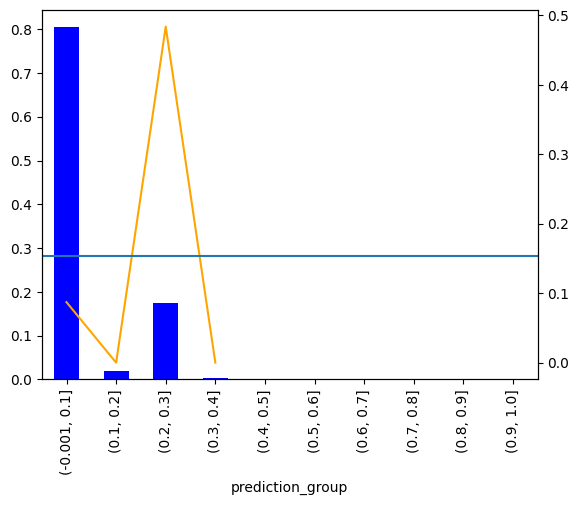

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       302
           1       0.00      0.00      0.00        55

    accuracy                           0.85       357
   macro avg       0.42      0.50      0.46       357
weighted avg       0.72      0.85      0.78       357

AUC Score: 0.8735099337748344


C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Inbal Geva\PycharmProjects\AlgotradingFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [37]:
present_scores(y_test, y_pred_proba, n_bins=10)

# Compute confusion matrix

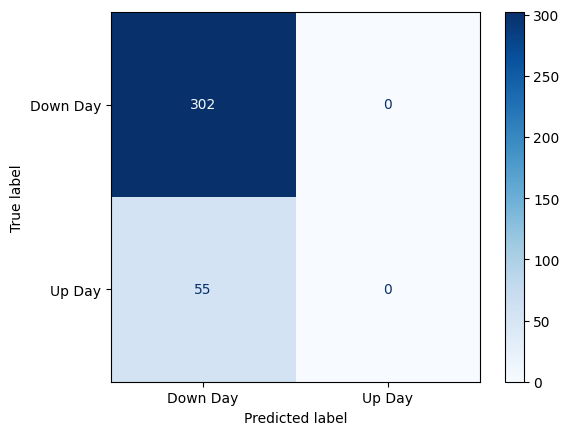

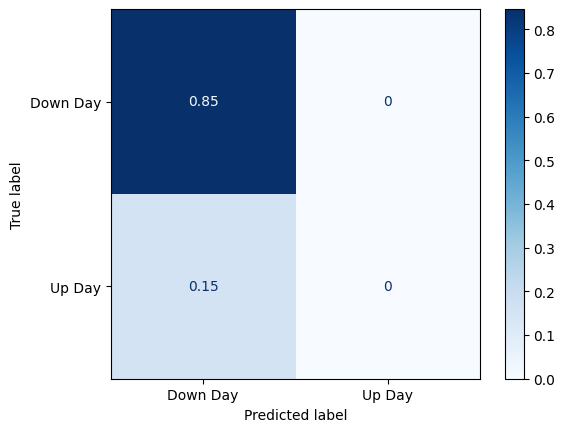

In [38]:
# Compute confusion matrix to evaluate the accuracy of the classification - displaying actual total values numbers per category

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)

plt.show()

# Compute confusion matrix to evaluate the accuracy of the classification - displaying normalized values numbers

cm = confusion_matrix(y_test, y_pred, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)

plt.show()



In [39]:

# הבר (המקל) הכחול מתאר כמה תצפיות יש בכל בין של הסתברות, למשל, בבין של 0.3 עד 0.4 יש 38% מהתצפיות
# הקו הכחול לעומתו, מתאר את המציאות - כמה ״1״-ים יש לנו במציאות
# הקו הכתום, תמיד צריך להיות משווה לקו הכחול, מעיד על אחוז הדיוק בבין
# נשים את הסף כל עוד הקו הכתום מעל הקו הכחול, או במינימום בנק׳ המפגש שלהם
# במודל טוב - ככל שההתסברות גבוהה יותר, כך הוא גם צודק יותר, ולכן בגדול הקו הכתום צריך לעלות, אבל זה לא המצב אצלנו

In [40]:
#create the profit function - based on the percentage of change in the "market cap percentage" column

# create prediction column in the "test" dataframe based on the model results, set it to binary number instead of True / False

test['prediction'] = y_pred.astype(int)
# test = test.reset_index()
test['profit_percentage'] = test['diff_in_mc_perc'] * test['prediction']
profit_perc_sum = round(test['profit_percentage'].sum(), 3)
profit_perc_mean = round(profit_perc_sum / test[test['prediction']==1].shape[0], 3)

print("The total profit in percentage after investing in AMGN stock is:",profit_perc_mean,"%")

The total profit in percentage after investing in AMGN stock is: nan %


C:\Users\Inbal Geva\AppData\Local\Temp\ipykernel_11364\2953161145.py:9: RuntimeWarning: invalid value encountered in double_scalars
  profit_perc_mean = round(profit_perc_sum / test[test['prediction']==1].shape[0], 3)
